# Advanced Fine-tuning: SFT vs DPO vs GRPO สำหรับ LLM

## เราจะใช้ Qwen3-0.6B (รองรับภาษาไทย + Thinking Mode)

ในบทเรียนนี้ เราจะเรียนรู้เทคนิคการ Fine-tune LLM **สามวิธี** และเปรียบเทียบผลลัพธ์:

1. **SFT (Supervised Fine-Tuning)** - สอนโมเดลด้วยตัวอย่างคำตอบที่ดี
2. **DPO (Direct Preference Optimization)** - สอนโมเดลด้วยคู่เปรียบเทียบ (ดี vs ไม่ดี)
3. **GRPO (Group Relative Policy Optimization)** - สอนโมเดลด้วย Reward Function (เช่น Math Verifier)

## สารบัญ
1. [ทำความเข้าใจ SFT, DPO และ GRPO](#1-ทำความเข้าใจ-sft-dpo-และ-grpo)
2. [ทำไมต้องใช้ Qwen3?](#2-ทำไมต้องใช้-qwen3)
3. [เตรียมสภาพแวดล้อม](#3-เตรียมสภาพแวดล้อม)
4. [โหลดข้อมูล](#4-โหลดข้อมูล)
5. [สร้าง Dataset และ DataLoader](#5-สร้าง-dataset-และ-dataloader)
6. [SFT: Supervised Fine-Tuning](#6-sft-supervised-fine-tuning)
7. [DPO: Direct Preference Optimization](#7-dpo-direct-preference-optimization)
8. [GRPO: Group Relative Policy Optimization](#8-grpo-group-relative-policy-optimization)
9. [เปรียบเทียบ SFT vs DPO vs GRPO](#9-เปรียบเทียบ-sft-vs-dpo-vs-grpo)
10. [สรุป](#10-สรุป)

---

**แปลและปรับปรุงโดย:** Kobkrit Viriyayudhakorn (กอบกฤตย์ วิริยะยุทธกร) | kobkrit@iapp.co.th | iApp Technology Co., Ltd.

**อ้างอิง:** Raschka, Sebastian. *Build A Large Language Model (From Scratch)*. Manning, 2024.

---
## 1. ทำความเข้าใจ SFT, DPO และ GRPO

### 🎯 เป้าหมายของการ Fine-tune LLM

หลังจาก Pre-training แล้ว โมเดล LLM มีความรู้มากมาย แต่ยังไม่รู้วิธี **"ตอบคำถาม"** อย่างเหมาะสม เราต้องสอนให้โมเดล:
- ตอบในรูปแบบที่เราต้องการ
- ใช้ภาษาที่ถูกต้อง (เช่น ตอบภาษาไทยเมื่อถูกถามเป็นภาษาไทย)
- มีเหตุผลและมีคุณภาพ
- **คำนวณได้ถูกต้อง** (สำหรับ GRPO)

---

### 📚 SFT (Supervised Fine-Tuning) - สอนด้วยตัวอย่าง

**SFT** = สอนโมเดลด้วย **ตัวอย่างคำตอบที่ดี** เพียงอย่างเดียว

#### 🎓 อุปมา: เหมือนการสอนนักเรียนด้วยหนังสือเรียน

```
📖 หนังสือเรียน (SFT Data):
   คำถาม: "2 + 2 เท่ากับเท่าไหร่?"
   คำตอบที่ถูกต้อง: "2 + 2 = 4"
   
👨‍🎓 นักเรียน (Model):
   เรียนรู้จากตัวอย่างที่ถูกต้องเท่านั้น
   ไม่รู้ว่าคำตอบอื่นผิดอย่างไร
```

---

### 🎯 DPO (Direct Preference Optimization) - สอนด้วยการเปรียบเทียบ

**DPO** = สอนโมเดลด้วย **คู่เปรียบเทียบ** ระหว่างคำตอบที่ดี (chosen) และคำตอบที่ไม่ดี (rejected)

#### 🎓 อุปมา: เหมือนการสอนด้วยการเปรียบเทียบ

```
📖 บทเรียน DPO:
   คำถาม: "อธิบาย AI"
   
   ✅ คำตอบที่ดี (Chosen): "AI คือปัญญาประดิษฐ์..." (ภาษาไทย)
   ❌ คำตอบที่ไม่ดี (Rejected): "AI is artificial..." (ภาษาอังกฤษ)
   
👨‍🎓 นักเรียน (Model):
   เรียนรู้ว่า "ตอบภาษาไทย ดีกว่า ตอบภาษาอังกฤษ"
   รู้ทั้งสิ่งที่ควรทำ และสิ่งที่ไม่ควรทำ
```

---

### 🚀 GRPO (Group Relative Policy Optimization) - สอนด้วย Reward Function

**GRPO** = สอนโมเดลโดยให้ **ลองตอบหลายครั้ง** แล้วเปรียบเทียบกับ **Reward Function**

#### 🎓 อุปมา: เหมือนการสอบแบบลองผิดลองถูกพร้อมเฉลย

```
📖 บทเรียน GRPO:
   คำถาม: "๕ + ๓ = ?"
   
   โมเดลลองตอบ 4 ครั้ง:
   📝 คำตอบ 1: "๘"  → ✅ ถูก! (Reward = 1.0)
   📝 คำตอบ 2: "๗"  → ❌ ผิด (Reward = 0.0)
   📝 คำตอบ 3: "๘"  → ✅ ถูก! (Reward = 1.0)
   📝 คำตอบ 4: "๑๐" → ❌ ผิด (Reward = 0.0)
   
   ค่าเฉลี่ย Reward = 0.5
   
   Advantage:
   - คำตอบ 1: 1.0 - 0.5 = +0.5 (ดีกว่าเฉลี่ย → ส่งเสริม)
   - คำตอบ 2: 0.0 - 0.5 = -0.5 (แย่กว่าเฉลี่ย → ลดทอน)
```

#### 💡 ข้อดีของ GRPO

1. **ไม่ต้องเตรียมข้อมูล chosen/rejected** - โมเดลสร้างเอง
2. **ใช้ Verifier ตรวจคำตอบ** - เหมาะกับงานที่ตรวจสอบได้ (เช่น คณิตศาสตร์, โค้ด)
3. **เรียนรู้จากความผิดพลาดของตัวเอง** - Self-improvement

---

### ⚖️ เปรียบเทียบ SFT vs DPO vs GRPO

| หัวข้อ | SFT | DPO | GRPO |
|--------|-----|-----|------|
| **ข้อมูลที่ใช้** | คำตอบที่ดีเท่านั้น | คู่เปรียบเทียบ | Prompt + Reward Function |
| **วิธีการเรียน** | เลียนแบบ | เปรียบเทียบ | ลองตอบหลายครั้ง |
| **จำนวนโมเดล** | 1 | 2 (Policy + Ref) | 1 (+ Reward Model/Verifier) |
| **Memory** | 1x | 2x | 1x + sampling |
| **เหมาะกับ** | สอนทักษะใหม่ | ปรับพฤติกรรม | งานที่ตรวจสอบได้ |

---

### 🎪 อุปมารวม: การสอนพนักงานใหม่

**SFT** เหมือนให้พนักงานอ่านคู่มือ:
- "เมื่อลูกค้าถามราคา ให้ตอบว่า..."

**DPO** เหมือนให้พนักงานดูวิดีโอเปรียบเทียบ:
- "นี่คือวิธีตอบที่ดี ✅ vs นี่คือวิธีตอบที่ไม่ดี ❌"

**GRPO** เหมือนให้พนักงานทดลองตอบลูกค้าจริง:
- ให้ลองตอบหลายแบบ แล้วดูว่าลูกค้าพึงพอใจแค่ไหน
- เรียนรู้จากผลตอบรับจริง (Reward)

---

### 📈 ลำดับการใช้งานทั่วไป

```
Pre-trained Model
      ↓
   [SFT] ← สอนให้ตอบคำถามได้ (Instruction Following)
      ↓
   [DPO] ← ปรับให้ตอบตามความชอบ (Preference Alignment)
      ↓
   [GRPO] ← เพิ่มความสามารถเฉพาะทาง (Math, Coding)
      ↓
Production Model
```

ในบทเรียนนี้ เราจะทดลองทั้ง SFT, DPO และ GRPO แยกกัน เพื่อเปรียบเทียบผลลัพธ์!

### 📊 ภาพรวม: SFT vs DPO vs GRPO

![SFT vs DPO vs GRPO Comparison](images/sft_dpo_grpo_comparison.png)

*รูปที่ 1: เปรียบเทียบเทคนิค Fine-tuning ทั้ง 3 แบบ*

---
## 2. ทำไมต้องใช้ Qwen3-0.6B?

### คุณสมบัติของ Qwen3-0.6B

| Feature | Qwen3-0.6B |
|---------|------------|
| **ภาษาไทย** | ✅ รองรับ (100+ ภาษา) |
| **Thinking Mode** | ✅ มี (`<think>` tags) |
| **Parameters** | 600M (เหมาะกับการเรียนรู้) |
| **Context Length** | 32,768 tokens |
| **License** | Apache 2.0 (ใช้เชิงพาณิชย์ได้) |

### Qwen3 Thinking Mode

Qwen3 รองรับ **Thinking Mode** ซึ่งโมเดลจะ:
1. คิดวิเคราะห์ใน `<think>...</think>` block ก่อน
2. แล้วจึงให้คำตอบสุดท้าย

```
<think>
คำถามนี้ต้องการให้อธิบายเกี่ยวกับ...
ฉันจะพิจารณาจากหลายมุมมอง...
</think>

คำตอบสุดท้ายที่ชัดเจน...
```

### ข้อมูล DPO ของเรา

Dataset ของเรามี `<think>` tags ซึ่งเหมาะสมกับ Qwen3:
- **Chosen**: คำตอบภาษาไทยพร้อม reasoning ✅
- **Rejected**: คำตอบภาษาอังกฤษ (ผิดภาษา) ❌

---
## 3. เตรียมสภาพแวดล้อม

### ความต้องการ

- **Python**: 3.10 - 3.12 (แนะนำ **Python 3.11**)
- **Memory**: ~5 GB RAM/VRAM สำหรับ DPO (2 โมเดล)

ติดตั้ง libraries ที่จำเป็น

In [1]:
# !nvidia-smi

In [2]:
# ตรวจสอบ Python version
import sys
print(f"Python version: {sys.version}")
assert sys.version_info >= (3, 10) and sys.version_info < (3, 13), \
    "ต้องการ Python 3.10 - 3.12 (แนะนำ 3.11)"

# ติดตั้ง packages ที่จำเป็น (รันครั้งเดียว)
# !pip install torch matplotlib tqdm safetensors huggingface_hub tokenizers requests

Python version: 3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:07:49) [Clang 20.1.8 ]


In [3]:
# ! wget https://raw.githubusercontent.com/kobkrit/thai_preference-tuning-with-dpo/refs/heads/main/qwen3.py

In [4]:
# Import libraries
import json
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

# ตรวจสอบ version
print(f"PyTorch version: {torch.__version__}")

# ตรวจสอบ device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

PyTorch version: 2.10.0
Using Apple Silicon GPU (MPS)


In [5]:
# Import Qwen3 Model และ Tokenizer
from qwen3 import (
    Qwen3Model,
    Qwen3Tokenizer,
    QWEN_CONFIG_06_B,
    load_weights_into_qwen,
    download_from_huggingface,
    download_from_huggingface_from_snapshots
)

print("✅ Qwen3 modules imported successfully")

✅ Qwen3 modules imported successfully


In [6]:
# Qwen3-0.6B Configuration
print("Qwen3-0.6B Configuration:")
print("=" * 40)
for k, v in QWEN_CONFIG_06_B.items():
    print(f"  {k}: {v}")

Qwen3-0.6B Configuration:
  vocab_size: 151936
  context_length: 40960
  emb_dim: 1024
  n_heads: 16
  n_layers: 28
  hidden_dim: 3072
  head_dim: 128
  qk_norm: True
  n_kv_groups: 8
  rope_base: 1000000.0
  dtype: torch.bfloat16


---
## 4. โหลดข้อมูล Preference

ข้อมูล Preference ประกอบด้วย:
- `instruction`: คำสั่งหรือคำถาม (ภาษาไทย)
- `input`: ข้อมูลเพิ่มเติม (optional)
- `chosen`: คำตอบที่ดี - ภาษาไทย พร้อม `<think>` reasoning
- `rejected`: คำตอบที่ไม่ดี - ภาษาอังกฤษ (ผิดภาษา)

In [7]:
# โหลดข้อมูล DPO ภาษาไทย
with open("dpo_thai_dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print(f"จำนวนข้อมูลทั้งหมด: {len(data)} รายการ")

จำนวนข้อมูลทั้งหมด: 100 รายการ


In [8]:
# ดูตัวอย่างข้อมูล
example = data[0]
print("=" * 60)
print("ตัวอย่างข้อมูล DPO:")
print("=" * 60)
print(f"\n📝 Instruction:\n{example['instruction'][:200]}...")
print(f"\n✅ Chosen (ภาษาไทย + <think>):\n{example['chosen'][:300]}...")
print(f"\n❌ Rejected (ภาษาอังกฤษ - ผิด!):\n{example['rejected'][:300]}...")

ตัวอย่างข้อมูล DPO:

📝 Instruction:
เขียนย่อหน้าเกี่ยวกับ โอกาสการลงทุนต่างๆ ท้ายปี 2021...

✅ Chosen (ภาษาไทย + <think>):
<think>
คำถามนี้เกี่ยวกับโอกาสในการลงทุนในช่วงปลายปี 2021 สิ่งสำคัญคือต้องเข้าใจบริบทของสถานการณ์ทางเศรษฐกิจและการเงินในช่วงเวลานั้น เพื่อให้สามารถระบุโอกาสการลงทุนที่เหมาะสมได้ ฉันจะพิจารณาปัจจัยต่างๆ เช่น อัตราดอกเบี้ย นโยบายการเงิน การฟื้นตัวทางเศรษฐกิจจากสถานการณ์โควิด-19 และแนวโน้มของตลาดต่างๆ ...

❌ Rejected (ภาษาอังกฤษ - ผิด!):
<think>
Okay, let's see. The user is asking about a 38-year-old Thai woman with heavy menstrual bleeding, difficulty in childbirth (maybe meaning postpartum issues?), and a lump on her abdomen. They want to know the chances of uterine fibroids.

First, I need to recall what uterine fibroids are. The...


### สังเกต:
- **Chosen**: ตอบเป็น**ภาษาไทย** พร้อม `<think>` reasoning ✅
- **Rejected**: ตอบเป็น**ภาษาอังกฤษ** (ผิดภาษา!) ❌

DPO จะสอนโมเดลให้:
1. ตอบเป็นภาษาไทยเมื่อถูกถามเป็นภาษาไทย
2. ใช้ reasoning ก่อนตอบ

In [9]:
# แบ่งข้อมูล 70% train, 15% val, 15% test
n = len(data)
train_size = int(0.7 * n)
val_size = int(0.15 * n)

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

print(f"Train: {len(train_data)} รายการ")
print(f"Validation: {len(val_data)} รายการ")
print(f"Test: {len(test_data)} รายการ")

Train: 70 รายการ
Validation: 15 รายการ
Test: 15 รายการ


---
## 5. สร้าง Dataset และ DataLoader

In [10]:
# โหลด Qwen3 Tokenizer
REPO_ID = "Qwen/Qwen3-0.6B"
LOCAL_DIR = "qwen3_weights"

# Download tokenizer
download_from_huggingface(
    repo_id=REPO_ID,
    filename="tokenizer.json",
    local_dir=LOCAL_DIR
)

# สร้าง tokenizer
tokenizer = Qwen3Tokenizer(
    tokenizer_file_path=f"{LOCAL_DIR}/tokenizer.json",
    repo_id=REPO_ID,
    apply_chat_template=False,  # เราจะจัดการ template เอง
    add_generation_prompt=False,
    add_thinking=False
)

print(f"✅ Tokenizer loaded")
print(f"Vocab size: {QWEN_CONFIG_06_B['vocab_size']:,}")
print(f"PAD token ID: {tokenizer.pad_token_id}")
print(f"EOS token ID: {tokenizer.eos_token_id}")

File already exists: qwen3_weights/tokenizer.json
✅ Tokenizer loaded
Vocab size: 151,936
PAD token ID: 151643
EOS token ID: 151645


In [11]:
# ทดสอบ tokenizer กับภาษาไทย
test_thai = "สวัสดีครับ นี่คือการทดสอบภาษาไทย"
tokens = tokenizer.encode(test_thai, chat_wrapped=False)
print(f"ข้อความ: {test_thai}")
print(f"Tokens: {tokens}")
print(f"จำนวน tokens: {len(tokens)}")
print(f"Decoded: {tokenizer.decode(tokens)}")

# เปรียบเทียบกับภาษาอังกฤษ
test_eng = "Hello, this is a test"
tokens_eng = tokenizer.encode(test_eng, chat_wrapped=False)
print(f"\nEnglish: {test_eng}")
print(f"Tokens: {len(tokens_eng)}")

ข้อความ: สวัสดีครับ นี่คือการทดสอบภาษาไทย
Tokens: [143126, 23271, 125136, 28319, 123886, 83546, 220, 20184, 47171, 40327, 83581, 93874, 139678, 127382, 125451]
จำนวน tokens: 15
Decoded: สวัสดีครับ นี่คือการทดสอบภาษาไทย

English: Hello, this is a test
Tokens: 6


In [12]:
def format_prompt_qwen3(entry):
    """
    จัดรูปแบบ prompt สำหรับ Qwen3 chat format
    """
    instruction = entry['instruction']
    input_text = entry.get('input', '')

    if input_text:
        user_content = f"{instruction}\n\nข้อมูลเพิ่มเติม: {input_text}"
    else:
        user_content = instruction

    # Qwen3 chat format
    prompt = f"<|im_start|>user\n{user_content}<|im_end|>\n<|im_start|>assistant\n"
    return prompt

In [13]:
# ทดสอบ format
example = data[0]
formatted = format_prompt_qwen3(example)
print("Formatted prompt:")
print(formatted[:300])

Formatted prompt:
<|im_start|>user
เขียนย่อหน้าเกี่ยวกับ โอกาสการลงทุนต่างๆ ท้ายปี 2021<|im_end|>
<|im_start|>assistant



In [14]:
class PreferenceDataset(Dataset):
    """
    Dataset สำหรับ DPO Training with Qwen3
    """
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pad_token_id = tokenizer.pad_token_id

        # Pre-process
        self.processed_data = []
        for entry in data:
            prompt = format_prompt_qwen3(entry)

            # Full sequences (prompt + response + end token)
            chosen_full = prompt + entry["chosen"] + "<|im_end|>"
            rejected_full = prompt + entry["rejected"] + "<|im_end|>"

            self.processed_data.append({
                "prompt": prompt,
                "chosen": chosen_full,
                "rejected": rejected_full
            })

    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        item = self.processed_data[idx]

        # Tokenize
        prompt_tokens = self.tokenizer.encode(item["prompt"], chat_wrapped=False)
        chosen_tokens = self.tokenizer.encode(item["chosen"], chat_wrapped=False)
        rejected_tokens = self.tokenizer.encode(item["rejected"], chat_wrapped=False)

        # Truncate
        prompt_tokens = prompt_tokens[:self.max_length]
        chosen_tokens = chosen_tokens[:self.max_length]
        rejected_tokens = rejected_tokens[:self.max_length]

        return {
            "prompt": torch.tensor(prompt_tokens),
            "chosen": torch.tensor(chosen_tokens),
            "rejected": torch.tensor(rejected_tokens),
            "prompt_length": len(prompt_tokens)
        }

In [15]:
def collate_fn(batch, pad_token_id, device="cpu"):
    """
    Collate function สำหรับ padding batch
    """
    max_chosen = max(len(item["chosen"]) for item in batch)
    max_rejected = max(len(item["rejected"]) for item in batch)
    max_prompt = max(len(item["prompt"]) for item in batch)

    chosen_list, rejected_list, prompt_list = [], [], []
    chosen_mask_list, rejected_mask_list = [], []

    for item in batch:
        # Pad chosen
        chosen = item["chosen"]
        chosen_padded = F.pad(chosen, (0, max_chosen - len(chosen)), value=pad_token_id)
        chosen_list.append(chosen_padded)

        chosen_mask = torch.ones(len(chosen))
        chosen_mask = F.pad(chosen_mask, (0, max_chosen - len(chosen)), value=0)
        chosen_mask_list.append(chosen_mask)

        # Pad rejected
        rejected = item["rejected"]
        rejected_padded = F.pad(rejected, (0, max_rejected - len(rejected)), value=pad_token_id)
        rejected_list.append(rejected_padded)

        rejected_mask = torch.ones(len(rejected))
        rejected_mask = F.pad(rejected_mask, (0, max_rejected - len(rejected)), value=0)
        rejected_mask_list.append(rejected_mask)

        # Pad prompt
        prompt = item["prompt"]
        prompt_padded = F.pad(prompt, (0, max_prompt - len(prompt)), value=pad_token_id)
        prompt_list.append(prompt_padded)

    return {
        "prompt": torch.stack(prompt_list).to(device),
        "chosen": torch.stack(chosen_list).to(device),
        "rejected": torch.stack(rejected_list).to(device),
        "chosen_mask": torch.stack(chosen_mask_list).to(device),
        "rejected_mask": torch.stack(rejected_mask_list).to(device)
    }

In [16]:
# สร้าง Dataset
train_dataset = PreferenceDataset(train_data, tokenizer, max_length=512)
val_dataset = PreferenceDataset(val_data, tokenizer, max_length=512)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

Train dataset: 70 samples
Val dataset: 15 samples


In [17]:
# สร้าง DataLoader
from functools import partial

custom_collate = partial(collate_fn, pad_token_id=tokenizer.pad_token_id, device=device)

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=custom_collate
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=custom_collate
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 35
Val batches: 8


In [18]:
# ทดสอบ DataLoader
batch = next(iter(train_loader))
print("Batch keys:", batch.keys())
print(f"Chosen shape: {batch['chosen'].shape}")
print(f"Rejected shape: {batch['rejected'].shape}")

Batch keys: dict_keys(['prompt', 'chosen', 'rejected', 'chosen_mask', 'rejected_mask'])
Chosen shape: torch.Size([2, 512])
Rejected shape: torch.Size([2, 512])


---
## 6. SFT: Supervised Fine-Tuning

### 🎯 เป้าหมายของ SFT

SFT จะสอนโมเดลให้เลียนแบบ **คำตอบที่ดี (chosen)** เท่านั้น โดยไม่สนใจคำตอบที่ไม่ดี

### 📊 SFT Loss อธิบายแบบละเอียด

$$\mathcal{L}_{SFT} = -\frac{1}{N} \sum_{i=1}^{N} \log P_\theta(y_i | x, y_{<i})$$

#### 🔍 แยกทำความเข้าใจทีละส่วน:

**1. $P_\theta(y_i | x, y_{<i})$** - ความน่าจะเป็นในการทำนายคำถัดไป

```
ตัวอย่าง: ถ้า x = "สวัสดี" และเราต้องการ y = "ครับ"

P(ค|สวัสดี) = 0.3      ← โมเดลคิดว่า "ค" มีโอกาส 30%
P(ร|สวัสดี,ค) = 0.8    ← ถ้าเห็น "ค" แล้ว "ร" มีโอกาส 80%
P(ั|สวัสดี,คร) = 0.9   ← ...
P(บ|สวัสดี,ครั) = 0.7
```

**2. $\log P$** - แปลงความน่าจะเป็นเป็น log

```
P = 0.9  →  log(0.9) = -0.105  (เกือบถูก ค่าติดลบน้อย)
P = 0.5  →  log(0.5) = -0.693  (ไม่แน่ใจ)
P = 0.1  →  log(0.1) = -2.303  (ผิดมาก ค่าติดลบมาก)
```

**3. $-\log P$** - กลับเครื่องหมายเพื่อให้เป็น Loss

```
P = 0.9  →  -log(0.9) = 0.105  (loss ต่ำ = ดี!)
P = 0.1  →  -log(0.1) = 2.303  (loss สูง = ต้องปรับปรุง)
```

#### 🍎 อุปมา: SFT Loss เหมือนครูให้คะแนนการอ่านออกเสียง

```
นักเรียนอ่าน: "แมว กิน ปลา"
ครูให้คะแนน:
  - "แมว" อ่านชัด (P=0.9) → คะแนนดี
  - "กิน" อ่านไม่ชัด (P=0.5) → คะแนนปานกลาง  
  - "ปลา" อ่านผิด (P=0.1) → คะแนนแย่

SFT Loss = เฉลี่ยคะแนนที่หักทั้งหมด
```

---

### 6.1 สร้าง SFT Dataset

SFT ใช้เฉพาะ **chosen** response (คำตอบที่ดี) ไม่ใช้ rejected

In [19]:
class SFTDataset(Dataset):
    """
    Dataset สำหรับ SFT Training
    ใช้เฉพาะ chosen response (คำตอบที่ดี) เท่านั้น
    """
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pad_token_id = tokenizer.pad_token_id

        # Pre-process - ใช้เฉพาะ chosen (ไม่ใช้ rejected)
        self.processed_data = []
        for entry in data:
            prompt = format_prompt_qwen3(entry)
            # SFT: prompt + chosen response + end token
            full_text = prompt + entry["chosen"] + "<|im_end|>"
            self.processed_data.append(full_text)

    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        text = self.processed_data[idx]
        tokens = self.tokenizer.encode(text, chat_wrapped=False)
        tokens = tokens[:self.max_length]
        return {"input_ids": torch.tensor(tokens)}


def sft_collate_fn(batch, pad_token_id, device="cpu"):
    """
    Collate function สำหรับ SFT - padding batch
    """
    max_len = max(len(item["input_ids"]) for item in batch)
    
    input_ids_list = []
    attention_mask_list = []
    
    for item in batch:
        ids = item["input_ids"]
        # Pad
        padded = F.pad(ids, (0, max_len - len(ids)), value=pad_token_id)
        input_ids_list.append(padded)
        
        # Attention mask
        mask = torch.ones(len(ids))
        mask = F.pad(mask, (0, max_len - len(ids)), value=0)
        attention_mask_list.append(mask)
    
    return {
        "input_ids": torch.stack(input_ids_list).to(device),
        "attention_mask": torch.stack(attention_mask_list).to(device)
    }


# สร้าง SFT Dataset
sft_train_dataset = SFTDataset(train_data, tokenizer, max_length=512)
sft_val_dataset = SFTDataset(val_data, tokenizer, max_length=512)

print(f"✅ SFT Train dataset: {len(sft_train_dataset)} samples")
print(f"✅ SFT Val dataset: {len(sft_val_dataset)} samples")
print(f"\n📝 ข้อแตกต่าง: SFT ใช้เฉพาะ chosen (คำตอบที่ดี) ไม่มี rejected")

✅ SFT Train dataset: 70 samples
✅ SFT Val dataset: 15 samples

📝 ข้อแตกต่าง: SFT ใช้เฉพาะ chosen (คำตอบที่ดี) ไม่มี rejected


In [20]:
# สร้าง SFT DataLoader
sft_custom_collate = partial(sft_collate_fn, pad_token_id=tokenizer.pad_token_id, device=device)

sft_train_loader = DataLoader(
    sft_train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=sft_custom_collate
)

sft_val_loader = DataLoader(
    sft_val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=sft_custom_collate
)

print(f"✅ SFT Train batches: {len(sft_train_loader)}")
print(f"✅ SFT Val batches: {len(sft_val_loader)}")

✅ SFT Train batches: 35
✅ SFT Val batches: 8


### 6.2 SFT Loss Function

SFT ใช้ **Cross-Entropy Loss** ซึ่งเป็น loss พื้นฐานที่สุดสำหรับการสอนภาษา

#### 📐 สูตร SFT Loss (Cross-Entropy)

$$\mathcal{L}_{SFT} = -\frac{1}{N} \sum_{i=1}^{N} \log P_\theta(y_i | x, y_{<i})$$

#### 🔍 Code Implementation อธิบายทีละบรรทัด

```python
def compute_sft_loss(logits, labels, mask):
    # 1. Shift logits และ labels
    #    logits[:-1] ทำนาย labels[1:]
    #    เพราะ LLM ทำนายคำถัดไป
    
    # 2. คำนวณ Cross-Entropy Loss
    #    = -log P(คำที่ถูกต้อง)
    
    # 3. ใช้ mask เพื่อไม่คิด loss บน padding tokens
```

#### 🎯 ทำไมต้อง Shift?

```
Input:  [สวัสดี] [ครับ] [ผม] [ชื่อ] [...]
         ↓        ↓      ↓     ↓
Output:  [ครับ]  [ผม]  [ชื่อ] [...]  ← ทำนายคำถัดไป

logits[0] ทำนาย labels[1]
logits[1] ทำนาย labels[2]
...
```

In [21]:
def compute_sft_loss(model, batch):
    """
    คำนวณ SFT Loss (Cross-Entropy)
    
    Parameters:
    -----------
    model: Qwen3Model - โมเดลที่จะ train
    batch: dict - Batch ของข้อมูล (input_ids, attention_mask)
    
    Returns:
    --------
    loss: torch.Tensor - Cross-Entropy Loss
    """
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    
    # Forward pass
    logits = model(input_ids)
    
    # Shift: logits[:-1] ทำนาย labels[1:]
    # เหตุผล: LLM ทำนายคำถัดไป ไม่ใช่คำปัจจุบัน
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()
    shift_mask = attention_mask[:, 1:].contiguous()
    
    # Flatten สำหรับ cross_entropy
    # จาก [batch, seq_len, vocab] → [batch*seq_len, vocab]
    shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    shift_labels = shift_labels.view(-1)
    shift_mask = shift_mask.view(-1)
    
    # Cross-Entropy Loss (ไม่ลด reduction เพื่อ apply mask เอง)
    loss = F.cross_entropy(shift_logits, shift_labels, reduction='none')
    
    # Apply mask - ไม่คิด loss บน padding tokens
    loss = (loss * shift_mask).sum() / shift_mask.sum().clamp(min=1)
    
    return loss

print("✅ compute_sft_loss function defined")

✅ compute_sft_loss function defined


### 6.3 SFT Training Loop

ตอนนี้เราจะ train โมเดลด้วย SFT ก่อน เพื่อดูผลลัพธ์

#### ⚠️ สำคัญ: SFT ใช้แค่ 1 โมเดล

```
SFT Memory:
┌─────────────────────┐
│   Policy Model      │  ← เพียงตัวเดียว!
│   (trainable)       │
│   ~1.2 GB          │
└─────────────────────┘
Total: ~2-3 GB (รวม gradients)
```

เปรียบเทียบกับ DPO ที่ต้องใช้ 2 โมเดล (4-5 GB)

In [22]:
# ดาวน์โหลด Qwen3-0.6B weights (ใช้ร่วมกันทั้ง SFT และ DPO)
print("="*60)
print("กำลังดาวน์โหลด Qwen3-0.6B weights...")
print("="*60)

weights = download_from_huggingface_from_snapshots(
    repo_id=REPO_ID,
    local_dir=LOCAL_DIR
)

print(f"\n✅ Downloaded {len(weights)} weight tensors")

กำลังดาวน์โหลด Qwen3-0.6B weights...


/Users/kobkrit/miniconda3/envs/thai_preference-tuning-with-dpo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 10 files: 100%|██████████| 10/10 [00:00<00:00, 4502.26it/s]



✅ Downloaded 311 weight tensors


In [23]:
# สร้าง SFT Model (แยกจาก DPO เพื่อเปรียบเทียบ)
print("="*60)
print("กำลังสร้าง SFT Model...")
print("="*60)

sft_model = Qwen3Model(QWEN_CONFIG_06_B)
load_weights_into_qwen(sft_model, QWEN_CONFIG_06_B, weights)
sft_model.to(device)

sft_params = sum(p.numel() for p in sft_model.parameters())
print(f"\n✅ SFT Model: {sft_params:,} parameters")
print(f"📊 Memory: ~{sft_params * 2 / 1e9:.1f} GB (BF16) + gradients")

กำลังสร้าง SFT Model...

✅ SFT Model: 751,632,384 parameters
📊 Memory: ~1.5 GB (BF16) + gradients


In [24]:
def train_sft(model, train_loader, val_loader, optimizer, num_epochs=2, eval_freq=10):
    """
    Training loop สำหรับ SFT
    """
    train_losses, val_losses = [], []
    global_step = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        progress_bar = tqdm(train_loader, desc=f"SFT Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            optimizer.zero_grad()

            loss = compute_sft_loss(model, batch)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

            global_step += 1

            if global_step % eval_freq == 0:
                val_loss = evaluate_sft(model, val_loader)
                train_losses.append(loss.item())
                val_losses.append(val_loss)

        avg_loss = epoch_loss / len(train_loader)
        print(f"\nSFT Epoch {epoch+1}: Average Loss = {avg_loss:.4f}")

    return {'train_losses': train_losses, 'val_losses': val_losses}


def evaluate_sft(model, val_loader):
    """Evaluate SFT model"""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            loss = compute_sft_loss(model, batch)
            total_loss += loss.item()

    model.train()
    return total_loss / len(val_loader)

In [25]:
# ตั้งค่า SFT Optimizer
sft_optimizer = torch.optim.AdamW(
    sft_model.parameters(),
    lr=5e-6,
    weight_decay=0.01
)

print("SFT Optimizer: AdamW")
print("Learning Rate: 5e-6")

SFT Optimizer: AdamW
Learning Rate: 5e-6


In [26]:
# เริ่ม SFT Training
print("="*60)
print("เริ่ม SFT Training with Qwen3-0.6B")
print("="*60)

sft_history = train_sft(
    model=sft_model,
    train_loader=sft_train_loader,
    val_loader=sft_val_loader,
    optimizer=sft_optimizer,
    num_epochs=2,
    eval_freq=5
)

เริ่ม SFT Training with Qwen3-0.6B


SFT Epoch 1/2: 100%|██████████| 35/35 [00:37<00:00,  1.09s/it, loss=1.1370]



SFT Epoch 1: Average Loss = 1.5742


SFT Epoch 2/2: 100%|██████████| 35/35 [00:37<00:00,  1.08s/it, loss=1.8171]


SFT Epoch 2: Average Loss = 1.4940


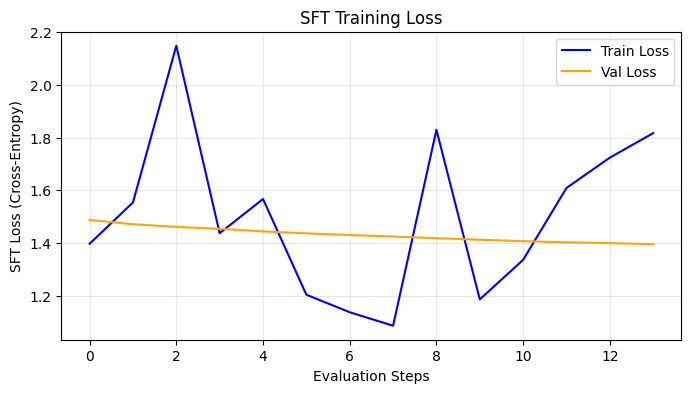


📊 SFT Loss ควรลดลงเรื่อยๆ


In [27]:
# Plot SFT training curves
plt.figure(figsize=(8, 4))
plt.plot(sft_history['train_losses'], label='Train Loss', color='blue')
plt.plot(sft_history['val_losses'], label='Val Loss', color='orange')
plt.xlabel('Evaluation Steps')
plt.ylabel('SFT Loss (Cross-Entropy)')
plt.title('SFT Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('sft_training_curves.png', dpi=150)
plt.show()

print("\n📊 SFT Loss ควรลดลงเรื่อยๆ")

In [28]:
def generate_response(model, tokenizer, prompt, max_new_tokens=200, temperature=0.6):
    """
    สร้างคำตอบจาก Qwen3
    ใช้สำหรับทดสอบ SFT, DPO, GRPO
    """
    model.eval()

    # Format prompt
    formatted = f"<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n"
    input_ids = tokenizer.encode(formatted, chat_wrapped=False)
    input_tensor = torch.tensor([input_ids]).to(device)

    # Generate
    with torch.no_grad():
        for _ in range(max_new_tokens):
            logits = model(input_tensor)
            logits = logits[:, -1, :] / temperature

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            input_tensor = torch.cat([input_tensor, next_token], dim=1)

            # Stop at EOS
            if next_token.item() == tokenizer.eos_token_id:
                break

    output = tokenizer.decode(input_tensor[0].tolist())
    return output

print("✅ generate_response function defined")

✅ generate_response function defined


In [29]:
# คำถามทดสอบ (ใช้ชุดเดียวกันสำหรับ Baseline, SFT, DPO, GRPO)
test_prompts = [
    "อธิบายว่า Machine Learning คืออะไร",
    "วิธีการดูแลสุขภาพที่ดี",
    "ประเทศไทยมีกี่จังหวัด"
]

# ทดสอบ SFT Model
print("="*60)
print("🟡 ทดสอบ Qwen3-0.6B หลัง SFT Training")
print("="*60)

sft_responses = []
for i, prompt in enumerate(test_prompts):
    print(f"\n📝 คำถาม {i+1}: {prompt}")
    print("-"*40)
    response = generate_response(sft_model, tokenizer, prompt, max_new_tokens=150)
    sft_responses.append(response)
    print(response)
    print("-"*40)

print("\n📊 SFT สอนให้โมเดลเลียนแบบคำตอบที่ดี (chosen)")
print("   แต่ไม่ได้สอนว่าอะไร 'ไม่ดี'")

🟡 ทดสอบ Qwen3-0.6B หลัง SFT Training

📝 คำถาม 1: อธิบายว่า Machine Learning คืออะไร
----------------------------------------
<|im_start|>user
อธิบายว่า Machine Learning คืออะไร<|im_end|>
<|im_start|>assistant
<think>
กล่าวถึงการเรียนรู้คือการเรียนรู้จากข้อมูล ซึมซับความรู้จากการเรียนรู้และใช้ในการแก้ปัญหา ซึ่งมีหลายวิธีในการเรียนรู้ ตัวอย่างเช่น เรียนรู้แบบสอนแบบมีชัย, เรียนรู้แบบมีส่วนร่วม, ใช้เทคนิคการเรียนรู้ทั้งแบบสตรีมและแบบสตรีมในบ้าน หรือใช้เทคนิคการเรียนรู้แบบสตรีมเพื่อให้เรียน
----------------------------------------

📝 คำถาม 2: วิธีการดูแลสุขภาพที่ดี
----------------------------------------
<|im_start|>user
วิธีการดูแลสุขภาพที่ดี<|im_end|>
<|im_start|>assistant
<think>
Okay, the user is asking for good health practices. Let me start by listing the main categories they might want. First, diet is a big one. I should mention balanced nutrition, including fruits, vegetables, whole grains, lean proteins, and healthy fats. Then, regular exercise. Maybe suggest activities like walki

---
## 7. DPO: Direct Preference Optimization

### 📊 DPO Loss คืออะไร?

DPO แตกต่างจาก SFT ตรงที่มันใช้ **การเปรียบเทียบ** ระหว่างคำตอบที่ดี (chosen) และคำตอบที่ไม่ดี (rejected)

### 🎯 สูตร DPO Loss

$$\mathcal{L}_{DPO} = -\log \sigma \left( \beta \left( \log \frac{\pi_\theta(y_w|x)}{\pi_{ref}(y_w|x)} - \log \frac{\pi_\theta(y_l|x)}{\pi_{ref}(y_l|x)} \right) \right)$$

### 🔍 อธิบายทีละส่วน:

| สัญลักษณ์ | ความหมาย |
|-----------|----------|
| $\pi_\theta$ | Policy model (โมเดลที่เรากำลัง train) |
| $\pi_{ref}$ | Reference model (โมเดลเริ่มต้น - frozen) |
| $y_w$ | **W**inner = Chosen response (คำตอบที่ดี - ภาษาไทย) |
| $y_l$ | **L**oser = Rejected response (คำตอบที่ไม่ดี - ภาษาอังกฤษ) |
| $\beta$ | Temperature parameter (ควบคุมความแรงของการปรับ) |
| $\sigma$ | Sigmoid function |

---

### 🧮 $\pi_\theta(y_w|x)$ คืออะไร? (สำคัญมาก!)

**$\pi_\theta(y_w|x)$ คือ ความน่าจะเป็นของการสร้าง response ทั้งหมด** - เป็น **scalar (ตัวเลขเดียว)** ไม่ใช่ vector!

#### วิธีคำนวณ: Product of Token Probabilities

สำหรับ Autoregressive LLM, เราคำนวณจาก **ผลคูณของความน่าจะเป็นแต่ละ token**:

$$\pi_\theta(y_w|x) = \prod_{t=1}^{T} P_\theta(y_t | x, y_{<t})$$

#### ตัวอย่างเป็นรูปธรรม

```
Input x: "อธิบาย AI"
Winner response y_w: "AI คือ ปัญญาประดิษฐ์" (5 tokens)

π_θ(y_w|x) = P("AI"|prompt) × P("คือ"|prompt,"AI") × P("ปัญญา"|...) × ...
           = 0.3 × 0.5 × 0.4 × 0.6 × 0.8
           = 0.0288  ← ตัวเลขเดียว (Scalar)!
```

#### ในทางปฏิบัติ: ใช้ Log Probability

เนื่องจากการคูณเลขเล็กๆ หลายตัวทำให้เกิด underflow, เราจึงใช้ **log**:

$$\log \pi_\theta(y_w|x) = \sum_{t=1}^{T} \log P_\theta(y_t | x, y_{<t})$$

```
log π_θ(y_w|x) = log(0.3) + log(0.5) + log(0.4) + log(0.6) + log(0.8)
               = -1.2 + -0.7 + -0.9 + -0.5 + -0.2
               = -3.5  ← ตัวเลขเดียว!
```

#### 📊 Visualization: จาก Logits → Scalar

![From Logits to π_θ(y|x)](images/logits_to_pi_theta.png)

*รูปที่: แสดงขั้นตอนการแปลง Logits → Log Probabilities → π_θ(y|x) Scalar*

---

### 🍎 อุปมา: DPO Loss เหมือนการแข่งขัน

```
🏆 การแข่งขันตอบคำถาม:

ผู้เข้าแข่งขัน A (Chosen - ภาษาไทย):
  - คะแนนจาก Policy: 8/10
  - คะแนนจาก Reference: 7/10
  - Log Ratio = log(8) - log(7) = +0.134 (ดีขึ้น!)

ผู้เข้าแข่งขัน B (Rejected - ภาษาอังกฤษ):
  - คะแนนจาก Policy: 6/10
  - คะแนนจาก Reference: 7/10
  - Log Ratio = log(6) - log(7) = -0.154 (แย่ลง)

ผลต่าง = A - B = 0.134 - (-0.154) = 0.288
→ A ชนะ! Loss ต่ำ (ดี)
```

### 🎯 เป้าหมายของ DPO

```
DPO ต้องการให้:
  chosen_ratio > rejected_ratio

นั่นคือ:
  โมเดลควรให้คะแนน "คำตอบภาษาไทย" สูงกว่าเดิม
  โมเดลควรให้คะแนน "คำตอบภาษาอังกฤษ" ต่ำกว่าเดิม
```

### อธิบาย DPO Loss แบบง่าย

---

## ข้อควรรู้: ต้องโหลด 2 โมเดลพร้อมกัน!

**DPO ต้องการ RAM/VRAM มากกว่าการ fine-tune ปกติ 2 เท่า** เพราะต้องโหลดโมเดล 2 ตัวในหน่วยความจำพร้อมกัน:

![DPO Memory Requirement](https://github.com/kobkrit/thai_preference-tuning-with-dpo/blob/main/images/dpo_memory_requirement.png?raw=1)

| โมเดล | หน้าที่ | สถานะ | Memory |
|-------|--------|-------|--------|
| **Policy Model** (π_θ) | โมเดลที่เรากำลัง train | Trainable (มี gradient) | ~100% |
| **Reference Model** (π_ref) | โมเดลอ้างอิง ก่อน train | Frozen (ไม่มี gradient) | ~100% |

### ตัวอย่างการใช้ Memory

```
Qwen3-0.6B:
- 1 โมเดล ≈ 1.2 GB (BF16)
- DPO (2 โมเดล) ≈ 2.4 GB + gradients ≈ 4-5 GB

Qwen3-4B:
- 1 โมเดล ≈ 8 GB (BF16)
- DPO (2 โมเดล) ≈ 16 GB + gradients ≈ 24-30 GB
```

**ทำไมต้องมี Reference Model?**
- ป้องกันโมเดลเปลี่ยนแปลงมากเกินไปจนลืมความรู้เดิม
- เป็น "จุดยึด" ให้โมเดลไม่หลุดไปไกล (Regularization)

---

## Visualization: DPO Loss ทำงานอย่างไร

### Step 1: Forward Pass ทั้ง 2 โมเดล

![DPO Forward Pass](https://github.com/kobkrit/thai_preference-tuning-with-dpo/blob/main/images/dpo_forward_pass.png?raw=1)

### Step 2: คำนวณ Log Ratio

![DPO Log Ratio](https://github.com/kobkrit/thai_preference-tuning-with-dpo/blob/main/images/dpo_log_ratio.png?raw=1)

### Step 3: DPO Loss

![DPO Loss Formula](https://github.com/kobkrit/thai_preference-tuning-with-dpo/blob/main/images/dpo_loss_formula.png?raw=1)

### 📊 DPO Loss Visualization

![DPO Loss Function Explained](images/dpo_loss_explained.png)

*รูปที่ 2: การทำงานของ DPO Loss - Sigmoid function และ Loss curve*

**อธิบายแผนภาพ:**
- **Sigmoid Function**: แปลง log ratio difference เป็น probability (0-1)
- **DPO Loss**: เมื่อ chosen มี log prob สูงกว่า rejected → loss ต่ำ ✅
- **เป้าหมาย**: เพิ่ม probability ของ chosen และลด probability ของ rejected

In [30]:
def compute_log_probs(logits, labels, mask=None):
    """
    คำนวณ log probability ของ tokens
    """
    # Shift: logits[:-1] ทำนาย labels[1:]
    logits = logits[:, :-1, :]
    labels = labels[:, 1:]

    # Log softmax
    log_softmax = F.log_softmax(logits, dim=-1)

    # Gather log probs
    selected_log_probs = torch.gather(
        log_softmax,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    if mask is not None:
        mask = mask[:, 1:]
        selected_log_probs = selected_log_probs * mask
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1).clamp(min=1)
    else:
        avg_log_prob = selected_log_probs.mean(-1)

    return avg_log_prob

In [31]:
def compute_dpo_loss(policy_model, reference_model, batch, beta=0.1):
    """
    คำนวณ DPO Loss

    Parameters:
    -----------
    policy_model: Qwen3Model - โมเดลที่จะ train
    reference_model: Qwen3Model - โมเดลอ้างอิง (frozen)
    batch: dict - Batch ของข้อมูล
    beta: float - Temperature parameter

    Returns:
    --------
    loss, chosen_reward, rejected_reward
    """
    chosen = batch["chosen"]
    rejected = batch["rejected"]
    chosen_mask = batch["chosen_mask"]
    rejected_mask = batch["rejected_mask"]

    # Forward pass - Policy model
    policy_chosen_logits = policy_model(chosen)
    policy_rejected_logits = policy_model(rejected)

    # Forward pass - Reference model (no gradient)
    with torch.no_grad():
        ref_chosen_logits = reference_model(chosen)
        ref_rejected_logits = reference_model(rejected)

    # คำนวณ log probs
    policy_chosen_log_probs = compute_log_probs(policy_chosen_logits, chosen, chosen_mask)
    policy_rejected_log_probs = compute_log_probs(policy_rejected_logits, rejected, rejected_mask)
    ref_chosen_log_probs = compute_log_probs(ref_chosen_logits, chosen, chosen_mask)
    ref_rejected_log_probs = compute_log_probs(ref_rejected_logits, rejected, rejected_mask)

    # Log ratios
    chosen_log_ratio = policy_chosen_log_probs - ref_chosen_log_probs
    rejected_log_ratio = policy_rejected_log_probs - ref_rejected_log_probs

    # DPO Loss
    logits = beta * (chosen_log_ratio - rejected_log_ratio)
    loss = -F.logsigmoid(logits).mean()

    # Rewards for monitoring
    chosen_reward = chosen_log_ratio.mean().detach()
    rejected_reward = rejected_log_ratio.mean().detach()

    return loss, chosen_reward, rejected_reward

### 7.1 โหลด Qwen3-0.6B สำหรับ DPO

DPO ต้องการ **2 โมเดล**:
1. **Policy Model** - โมเดลที่จะ train
2. **Reference Model** - โมเดลอ้างอิง (frozen)

In [32]:
# weights ถูกดาวน์โหลดไว้แล้วในส่วน SFT
# ตรวจสอบว่ามี weights อยู่แล้ว
print(f"✅ Weights already loaded: {len(weights)} tensors")

✅ Weights already loaded: 311 tensors


In [33]:
print("กำลังสร้าง Policy Model...")
policy_model = Qwen3Model(QWEN_CONFIG_06_B)
load_weights_into_qwen(policy_model, QWEN_CONFIG_06_B, weights)
policy_model.to(device)

print("กำลังสร้าง Reference Model...")
reference_model = Qwen3Model(QWEN_CONFIG_06_B)
load_weights_into_qwen(reference_model, QWEN_CONFIG_06_B, weights)
reference_model.to(device)

# Freeze reference model
for param in reference_model.parameters():
    param.requires_grad = False

# Count parameters
total_params = sum(p.numel() for p in policy_model.parameters())
trainable_params = sum(p.numel() for p in policy_model.parameters() if p.requires_grad)

print(f"\n✅ โมเดลโหลดเสร็จ!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\n⚠️ หมายเหตุ: ใช้ memory ~{total_params * 4 / 1e9:.1f} GB (2 โมเดล × BF16)")

กำลังสร้าง Policy Model...
กำลังสร้าง Reference Model...

✅ โมเดลโหลดเสร็จ!
Total parameters: 751,632,384
Trainable parameters: 751,632,384

⚠️ หมายเหตุ: ใช้ memory ~3.0 GB (2 โมเดล × BF16)


### 7.2 ทดสอบโมเดลก่อน DPO (Baseline)

ก่อนที่จะ train ด้วย DPO เรามาทดสอบดูก่อนว่า **โมเดล Qwen3-0.6B ดั้งเดิม** ตอบคำถามภาษาไทยอย่างไร

เราจะใช้คำถามชุดเดียวกันกับที่จะทดสอบหลัง DPO เพื่อเปรียบเทียบผลลัพธ์

In [34]:
# generate_response ถูกกำหนดไว้แล้วในส่วน SFT
# ใช้ฟังก์ชันเดียวกันสำหรับทดสอบทุกโมเดล
print("✅ Using generate_response function (defined in SFT section)")

✅ Using generate_response function (defined in SFT section)


In [35]:
# ใช้ test_prompts ที่กำหนดไว้แล้วในส่วน SFT
print("="*60)
print("🔵 ทดสอบ Qwen3-0.6B ก่อน DPO (Baseline)")
print("="*60)

baseline_responses = []
for i, prompt in enumerate(test_prompts):
    print(f"\n📝 คำถาม {i+1}: {prompt}")
    print("-"*40)
    response = generate_response(policy_model, tokenizer, prompt, max_new_tokens=150)
    baseline_responses.append(response)
    print(response)
    print("-"*40)

print("\n⚠️ สังเกต: โมเดลอาจตอบเป็นภาษาอังกฤษหรือผสมภาษา")

🔵 ทดสอบ Qwen3-0.6B ก่อน DPO (Baseline)

📝 คำถาม 1: อธิบายว่า Machine Learning คืออะไร
----------------------------------------
<|im_start|>user
อธิบายว่า Machine Learning คืออะไร<|im_end|>
<|im_start|>assistant
<think>
Okay, the user is asking about what Machine Learning is. I need to explain it clearly. Let me start by defining it. I should mention that it's a subset of artificial intelligence that allows machines to learn from data. Then, maybe break it down into key components like supervised, unsupervised, and reinforcement learning. I should also include examples to make it relatable. Oh, and maybe touch on the applications since the user might be interested in real-world uses. Let me check if I have all the basics covered. Oh, and make sure the explanation is easy to understand without jargon. Alright, that should cover it.
</think>

Machine Learning (ML) คือ วิชาการที่ศึกษา
----------------------------------------

📝 คำถาม 2: วิธีการดูแลสุขภาพที่ดี
------------------------------

### 7.3 Training Loop

In [36]:
def train_dpo(
    policy_model,
    reference_model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=3,
    beta=0.1,
    eval_freq=10
):
    """
    Training loop สำหรับ DPO
    """
    train_losses, val_losses, reward_margins = [], [], []
    global_step = 0

    for epoch in range(num_epochs):
        policy_model.train()
        epoch_loss = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            optimizer.zero_grad()

            loss, chosen_reward, rejected_reward = compute_dpo_loss(
                policy_model, reference_model, batch, beta=beta
            )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            reward_margin = chosen_reward.item() - rejected_reward.item()

            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'margin': f'{reward_margin:.4f}'
            })

            global_step += 1

            if global_step % eval_freq == 0:
                val_loss = evaluate_dpo(policy_model, reference_model, val_loader, beta)
                train_losses.append(loss.item())
                val_losses.append(val_loss)
                reward_margins.append(reward_margin)

        avg_loss = epoch_loss / len(train_loader)
        print(f"\nEpoch {epoch+1}: Average Loss = {avg_loss:.4f}")

    return {'train_losses': train_losses, 'val_losses': val_losses, 'reward_margins': reward_margins}


def evaluate_dpo(policy_model, reference_model, val_loader, beta=0.1):
    policy_model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            loss, _, _ = compute_dpo_loss(policy_model, reference_model, batch, beta=beta)
            total_loss += loss.item()

    policy_model.train()
    return total_loss / len(val_loader)

In [37]:
# ตั้งค่า Optimizer
optimizer = torch.optim.AdamW(
    policy_model.parameters(),
    lr=5e-6,
    weight_decay=0.01
)

print("Optimizer: AdamW")
print("Learning Rate: 5e-6")
print("Beta (DPO): 0.1")

Optimizer: AdamW
Learning Rate: 5e-6
Beta (DPO): 0.1


In [38]:
# เริ่ม Training
print("="*60)
print("เริ่ม DPO Training with Qwen3-0.6B")
print("="*60)

history = train_dpo(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=2,
    beta=0.1,
    eval_freq=5
)

เริ่ม DPO Training with Qwen3-0.6B


Epoch 1/2: 100%|██████████| 35/35 [01:49<00:00,  3.12s/it, loss=0.6918, margin=0.0261]



Epoch 1: Average Loss = 0.6919


Epoch 2/2: 100%|██████████| 35/35 [01:48<00:00,  3.10s/it, loss=0.6884, margin=0.0961]


Epoch 2: Average Loss = 0.6862


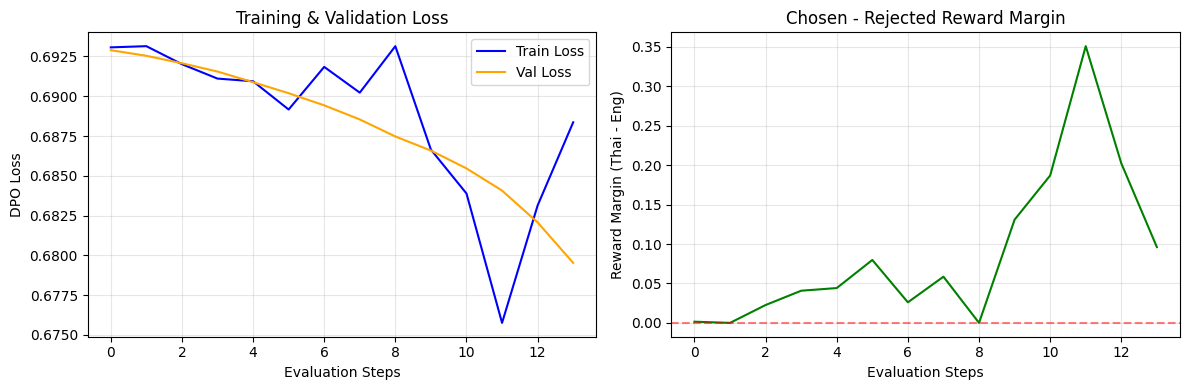


📊 กราฟแสดง:
- Loss ควรลดลง
- Reward Margin ควรเพิ่มขึ้น (Thai > Eng)


In [39]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_losses'], label='Train Loss', color='blue')
axes[0].plot(history['val_losses'], label='Val Loss', color='orange')
axes[0].set_xlabel('Evaluation Steps')
axes[0].set_ylabel('DPO Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['reward_margins'], color='green')
axes[1].set_xlabel('Evaluation Steps')
axes[1].set_ylabel('Reward Margin (Thai - Eng)')
axes[1].set_title('Chosen - Rejected Reward Margin')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dpo_training_curves.png', dpi=150)
plt.show()

print("\n📊 กราฟแสดง:")
print("- Loss ควรลดลง")
print("- Reward Margin ควรเพิ่มขึ้น (Thai > Eng)")

---
## 8. GRPO: Group Relative Policy Optimization

### 🚀 GRPO คืออะไร?

**GRPO** (Group Relative Policy Optimization) เป็นเทคนิคจาก DeepSeek ที่ใช้ใน DeepSeekMath และ DeepSeek-R1

#### 💡 แนวคิดหลัก

```
แทนที่จะให้ข้อมูล chosen/rejected ล่วงหน้า (เหมือน DPO)
GRPO ให้โมเดลลองตอบหลายครั้ง แล้วเปรียบเทียบกับ Reward Function

เหมาะกับงานที่ตรวจสอบคำตอบได้ เช่น:
- คณิตศาสตร์ (ตรวจสอบด้วย Math Verifier)
- โค้ด (ตรวจสอบด้วย Test Cases)
- Logic Puzzles (ตรวจสอบด้วย Rules)
```

### 📊 GRPO Loss Formula

$$\mathcal{L}_{GRPO} = -\sum_{j=1}^{M} \sum_{k=1}^{K} \frac{\pi_\theta(o_{jk}|q_j)}{\pi_{\theta_{old}}(o_{jk}|q_j)} \cdot A_{jk} + \beta \cdot KL(\pi_\theta || \pi_{\theta_{old}})$$

#### 🔍 อธิบายทีละส่วน:

| สัญลักษณ์ | ความหมาย |
|-----------|----------|
| $M$ | จำนวน prompts ใน batch |
| $K$ | จำนวนคำตอบที่ generate ต่อ prompt |
| $\pi_\theta$ | Policy ปัจจุบัน (โมเดลที่กำลัง train) |
| $\pi_{\theta_{old}}$ | Policy เก่า (ก่อน update) |
| $A_{jk}$ | **Advantage** ของคำตอบ k สำหรับ prompt j |
| $\beta$ | ค่าคงที่สำหรับ KL penalty |

### 🎯 Advantage คำนวณอย่างไร?

$$A_{jk} = R_{jk} - \bar{R}_j$$

- **$R_{jk}$** = Reward ของคำตอบ k (จาก Verifier)
- **$\bar{R}_j$** = ค่าเฉลี่ย Reward ของทุกคำตอบสำหรับ prompt j

#### 🍎 อุปมา: GRPO เหมือนการแข่งขันภายในกลุ่ม

```
🏆 การแข่งขันคณิตศาสตร์ในห้อง:

คำถาม: "๕ × ๓ = ?"
นักเรียน 4 คนตอบ:
  - คนที่ 1: "๑๕" → ถูก! (Reward = 1.0)
  - คนที่ 2: "๑๒" → ผิด  (Reward = 0.0)
  - คนที่ 3: "๑๕" → ถูก! (Reward = 1.0)
  - คนที่ 4: "๘"  → ผิด  (Reward = 0.0)

ค่าเฉลี่ยห้อง = 0.5

Advantage (เทียบกับค่าเฉลี่ยห้อง):
  - คนที่ 1: 1.0 - 0.5 = +0.5 (ดีกว่าเพื่อน → ยกย่อง)
  - คนที่ 2: 0.0 - 0.5 = -0.5 (แย่กว่าเพื่อน → ปรับปรุง)

GRPO สอนให้โมเดล "เลียนแบบคนเก่งในกลุ่ม"
```

### 🔢 Thai Math Dataset

เราจะสร้าง Dataset คณิตศาสตร์ภาษาไทยด้วย **เลขไทย** (๐๑๒๓๔๕๖๗๘๙)

#### ทำไมต้องใช้เลขไทย?

1. **ท้าทายโมเดล** - โมเดลส่วนใหญ่ไม่เคยเห็นการคำนวณด้วยเลขไทย
2. **ทดสอบความสามารถ** - ดูว่าโมเดลเข้าใจ "ค่าตัวเลข" หรือแค่ "รูปแบบตัวเลข"
3. **Use case ไทย** - เหมาะกับการใช้งานในบริบทไทย

```python
# ตารางแปลงเลขไทย
๐ = 0, ๑ = 1, ๒ = 2, ๓ = 3, ๔ = 4
๕ = 5, ๖ = 6, ๗ = 7, ๘ = 8, ๙ = 9
```

### 📊 GRPO Algorithm Flow

![GRPO Algorithm Flow](images/grpo_algorithm_flow.png)

*รูปที่ 3: ขั้นตอนการทำงานของ GRPO*

**อธิบายแผนภาพ:**
1. รับ prompt (คำถาม) เช่น "๕ + ๓ = ?"
2. Generate K คำตอบ (เช่น K=4)
3. ให้คะแนน Reward แต่ละคำตอบ (1.0 ถ้าถูก, 0.0 ถ้าผิด)
4. คำนวณ Advantage = Reward - Mean(Rewards)
5. อัพเดทโมเดลให้เพิ่ม probability ของคำตอบที่มี Advantage สูง

In [40]:
# Thai Numeral Utilities
import random

# Thai numeral mapping
THAI_DIGITS = "๐๑๒๓๔๕๖๗๘๙"
ARABIC_DIGITS = "0123456789"

def arabic_to_thai(num):
    """แปลงเลขอารบิกเป็นเลขไทย"""
    return str(num).translate(str.maketrans(ARABIC_DIGITS, THAI_DIGITS))

def thai_to_arabic(thai_num):
    """แปลงเลขไทยเป็นเลขอารบิก"""
    return thai_num.translate(str.maketrans(THAI_DIGITS, ARABIC_DIGITS))

def thai_to_int(thai_num):
    """แปลงเลขไทยเป็น int"""
    try:
        return int(thai_to_arabic(thai_num))
    except:
        return None

# ทดสอบ
print("ทดสอบการแปลงเลขไทย:")
print(f"  123 → {arabic_to_thai(123)}")
print(f"  ๔๕๖ → {thai_to_arabic('๔๕๖')}")
print(f"  ๗๘๙ → {thai_to_int('๗๘๙')}")

ทดสอบการแปลงเลขไทย:
  123 → ๑๒๓
  ๔๕๖ → 456
  ๗๘๙ → 789


In [41]:
def generate_thai_math_problem():
    """สร้างโจทย์คณิตศาสตร์ภาษาไทย"""
    ops = ['+', '-', '×', '÷']
    op = random.choice(ops)
    
    if op == '+':
        a = random.randint(1, 50)
        b = random.randint(1, 50)
        answer = a + b
    elif op == '-':
        a = random.randint(10, 50)
        b = random.randint(1, a)  # ให้ผลลัพธ์เป็นบวก
        answer = a - b
    elif op == '×':
        a = random.randint(1, 12)
        b = random.randint(1, 12)
        answer = a * b
    else:  # ÷
        b = random.randint(1, 10)
        answer = random.randint(1, 10)
        a = b * answer  # ให้หารลงตัว
    
    # แปลงเป็นเลขไทย
    thai_a = arabic_to_thai(a)
    thai_b = arabic_to_thai(b)
    thai_answer = arabic_to_thai(answer)
    
    question = f"{thai_a} {op} {thai_b} = ?"
    return {
        "question": question,
        "answer": thai_answer,
        "arabic_answer": answer,
        "operation": op
    }

# สร้าง Thai Math Dataset (fixed seed for reproducibility)
random.seed(123)
thai_math_data = [generate_thai_math_problem() for _ in range(100)]

# บันทึกเป็นไฟล์ JSON
with open('thai_math_dataset.json', 'w', encoding='utf-8') as f:
    json.dump(thai_math_data, f, ensure_ascii=False, indent=2)

print(f"✅ สร้างและบันทึก Thai Math Dataset: {len(thai_math_data)} โจทย์")
print(f"📁 บันทึกไฟล์: thai_math_dataset.json")

print("\n" + "="*60)
print("📊 ตัวอย่างข้อมูล Thai Math Dataset")
print("="*60)
print("\nตัวอย่างจาก JSON:")
print(json.dumps(thai_math_data[:3], ensure_ascii=False, indent=2))

print("\n" + "="*60)
print("📈 สถิติ Dataset")
print("="*60)
op_counts = {}
for p in thai_math_data:
    op = p['operation']
    op_counts[op] = op_counts.get(op, 0) + 1

print("การกระจายตาม Operation:")
for op, count in sorted(op_counts.items()):
    op_name = {'+': 'บวก', '-': 'ลบ', '×': 'คูณ', '÷': 'หาร'}[op]
    print(f"  {op} ({op_name}): {count} โจทย์")

print("\nตัวอย่างโจทย์แต่ละประเภท:")
for op in ['+', '-', '×', '÷']:
    examples = [p for p in thai_math_data if p['operation'] == op][:2]
    for ex in examples:
        print(f"  {ex['question']} → {ex['answer']} (arabic: {ex['arabic_answer']})")

✅ สร้างและบันทึก Thai Math Dataset: 100 โจทย์
📁 บันทึกไฟล์: thai_math_dataset.json

📊 ตัวอย่างข้อมูล Thai Math Dataset

ตัวอย่างจาก JSON:
[
  {
    "question": "๑๘ + ๖ = ?",
    "answer": "๒๔",
    "arabic_answer": 24,
    "operation": "+"
  },
  {
    "question": "๑๐ ÷ ๕ = ?",
    "answer": "๒",
    "arabic_answer": 2,
    "operation": "÷"
  },
  {
    "question": "๒๕ + ๓๕ = ?",
    "answer": "๖๐",
    "arabic_answer": 60,
    "operation": "+"
  }
]

📈 สถิติ Dataset
การกระจายตาม Operation:
  + (บวก): 26 โจทย์
  - (ลบ): 16 โจทย์
  × (คูณ): 26 โจทย์
  ÷ (หาร): 32 โจทย์

ตัวอย่างโจทย์แต่ละประเภท:
  ๑๘ + ๖ = ? → ๒๔ (arabic: 24)
  ๒๕ + ๓๕ = ? → ๖๐ (arabic: 60)
  ๑๘ - ๑๑ = ? → ๗ (arabic: 7)
  ๑๐ - ๗ = ? → ๓ (arabic: 3)
  ๖ × ๑ = ? → ๖ (arabic: 6)
  ๑๒ × ๔ = ? → ๔๘ (arabic: 48)
  ๑๐ ÷ ๕ = ? → ๒ (arabic: 2)
  ๒ ÷ ๒ = ? → ๑ (arabic: 1)


### 8.1 Math Verifier (Reward Function)

Verifier จะตรวจคำตอบและให้ Reward:
- **Reward = 1.0** ถ้าคำตอบถูกต้อง
- **Reward = 0.0** ถ้าคำตอบผิด

In [42]:
import re

def extract_answer_from_response(response):
    """ดึงคำตอบจาก response ของโมเดล"""
    # ลองหาเลขไทยก่อน
    thai_nums = re.findall(r'[๐-๙]+', response)
    if thai_nums:
        return thai_nums[-1]  # เอาตัวสุดท้าย (น่าจะเป็นคำตอบ)
    
    # ลองหาเลขอารบิก
    arabic_nums = re.findall(r'\d+', response)
    if arabic_nums:
        return arabic_to_thai(arabic_nums[-1])
    
    return None

def math_verifier(response, correct_answer):
    """
    ตรวจสอบคำตอบคณิตศาสตร์
    
    Returns:
        reward: 1.0 ถ้าถูก, 0.0 ถ้าผิด
    """
    extracted = extract_answer_from_response(response)
    
    if extracted is None:
        return 0.0
    
    # แปลงทั้งคู่เป็น int เพื่อเปรียบเทียบ
    extracted_int = thai_to_int(extracted)
    correct_int = thai_to_int(correct_answer)
    
    if extracted_int is not None and extracted_int == correct_int:
        return 1.0
    return 0.0

# ทดสอบ Verifier
test_cases = [
    ("คำตอบคือ ๘", "๘"),      # ถูก
    ("I think it's ๑๒", "๑๒"),  # ถูก
    ("Answer is 15", "๑๕"),     # ถูก (อารบิก = ไทย)
    ("คำตอบคือ ๗", "๘"),        # ผิด
]

print("ทดสอบ Math Verifier:")
for response, answer in test_cases:
    reward = math_verifier(response, answer)
    status = "✅" if reward == 1.0 else "❌"
    print(f"  {status} Response: '{response}' | Answer: {answer} | Reward: {reward}")

ทดสอบ Math Verifier:
  ✅ Response: 'คำตอบคือ ๘' | Answer: ๘ | Reward: 1.0
  ✅ Response: 'I think it's ๑๒' | Answer: ๑๒ | Reward: 1.0
  ✅ Response: 'Answer is 15' | Answer: ๑๕ | Reward: 1.0
  ❌ Response: 'คำตอบคือ ๗' | Answer: ๘ | Reward: 0.0


### 8.2 ทดสอบโมเดลก่อน GRPO (Math Baseline)

มาดูว่า Qwen3-0.6B คำนวณเลขไทยได้ดีแค่ไหนก่อน GRPO

In [43]:
# สร้าง GRPO Model (copy จาก base weights)
print("="*60)
print("กำลังสร้าง GRPO Model...")
print("="*60)

grpo_model = Qwen3Model(QWEN_CONFIG_06_B)
load_weights_into_qwen(grpo_model, QWEN_CONFIG_06_B, weights)
grpo_model.to(device)

print(f"✅ GRPO Model ready")

กำลังสร้าง GRPO Model...
✅ GRPO Model ready


In [44]:
# ============================================================
# 🔵 ทดสอบ Qwen3-0.6B กับเลขอารบิก (Western Arabic Numerals)
# ============================================================
# ก่อนทดสอบเลขไทย มาดูว่า Qwen3 คำนวณเลขอารบิกปกติได้ไหม

def generate_math_response(model, tokenizer, question, max_new_tokens=50, temperature=0.7):
    """สร้างคำตอบสำหรับโจทย์คณิตศาสตร์"""
    model.eval()
    
    prompt = f"<|im_start|>user\nคำนวณ: {question}<|im_end|>\n<|im_start|>assistant\n"
    input_ids = tokenizer.encode(prompt, chat_wrapped=False)
    input_tensor = torch.tensor([input_ids]).to(device)
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            logits = model(input_tensor)
            logits = logits[:, -1, :] / temperature
            
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            input_tensor = torch.cat([input_tensor, next_token], dim=1)
            
            if next_token.item() == tokenizer.eos_token_id:
                break
    
    output = tokenizer.decode(input_tensor[0].tolist())
    # Extract only the assistant's response
    if "<|im_start|>assistant" in output:
        response = output.split("<|im_start|>assistant")[-1]
        response = response.replace("<|im_end|>", "").strip()
        return response
    return output


def generate_arabic_math_problem():
    """สร้างโจทย์คณิตศาสตร์เลขอารบิก (ไม่แปลงเป็นเลขไทย)"""
    ops = ['+', '-', '×', '÷']
    op = random.choice(ops)
    
    if op == '+':
        a = random.randint(1, 50)
        b = random.randint(1, 50)
        answer = a + b
    elif op == '-':
        a = random.randint(10, 50)
        b = random.randint(1, a)
        answer = a - b
    elif op == '×':
        a = random.randint(1, 12)
        b = random.randint(1, 12)
        answer = a * b
    else:  # ÷
        b = random.randint(1, 10)
        answer = random.randint(1, 10)
        a = b * answer
    
    question = f"{a} {op} {b} = ?"
    return {
        "question": question,
        "answer": str(answer),
        "arabic_answer": answer,
        "operation": op
    }

def arabic_math_verifier(response, correct_answer):
    """ตรวจคำตอบเลขอารบิก"""
    # ดึงตัวเลขจาก response
    numbers = re.findall(r'\d+', response)
    if numbers:
        # ตรวจสอบว่าคำตอบถูกต้องหรือไม่
        for num in numbers:
            if num == correct_answer:
                return 1.0
    return 0.0

# สร้างโจทย์เลขอารบิก
random.seed(42)  # Fixed seed for reproducibility
arabic_math_problems = [generate_arabic_math_problem() for _ in range(20)]

print("="*60)
print("🔢 ทดสอบ Qwen3-0.6B กับเลขอารบิก (Western Numerals)")
print("="*60)
print("\nตัวอย่างโจทย์เลขอารบิก:")
for i, p in enumerate(arabic_math_problems[:5]):
    print(f"  {i+1}. {p['question']} → {p['answer']}")

# ใช้ grpo_model ที่โหลดไว้แล้ว (base model)
print("\n" + "="*60)
print("ทดสอบการคำนวณเลขอารบิก:")
print("="*60)

arabic_correct = 0
for i, problem in enumerate(arabic_math_problems[:10]):
    response = generate_math_response(grpo_model, tokenizer, problem['question'])
    reward = arabic_math_verifier(response, problem['answer'])
    arabic_correct += reward
    status = "✅" if reward == 1.0 else "❌"
    print(f"{status} {problem['question']} → Model: {response[:30]}... | Correct: {problem['answer']}")

arabic_accuracy = arabic_correct / 10 * 100
print(f"\n📊 Arabic Numeral Accuracy: {arabic_accuracy:.1f}% ({int(arabic_correct)}/10)")
print("\n💡 สังเกต: Qwen3-0.6B สามารถคำนวณเลขอารบิกได้ดีกว่าเลขไทยมาก!")

🔢 ทดสอบ Qwen3-0.6B กับเลขอารบิก (Western Numerals)

ตัวอย่างโจทย์เลขอารบิก:
  1. 2 + 48 = ? → 50
  2. 4 × 4 = ? → 16
  3. 16 - 3 = ? → 13
  4. 1 ÷ 1 = ? → 1
  5. 14 + 15 = ? → 29

ทดสอบการคำนวณเลขอารบิก:
❌ 2 + 48 = ? → Model: <think>
Okay, let's see. The p... | Correct: 50
❌ 4 × 4 = ? → Model: <think>
Okay, so I need to cal... | Correct: 16
❌ 16 - 3 = ? → Model: <think>
Okay, let's see. The p... | Correct: 13
✅ 1 ÷ 1 = ? → Model: <think>
Okay, so I need to fig... | Correct: 1
❌ 14 + 15 = ? → Model: <think>
Okay, let's see. The p... | Correct: 29
❌ 36 + 13 = ? → Model: <think>
Okay, let's see. The p... | Correct: 49
❌ 32 ÷ 4 = ? → Model: <think>
Okay, so I need to cal... | Correct: 8
✅ 1 × 3 = ? → Model: <think>
Okay, so I need to cal... | Correct: 3
❌ 30 ÷ 6 = ? → Model: <think>
Okay, let's see. I nee... | Correct: 5
❌ 23 - 11 = ? → Model: <think>
Okay, so I need to cal... | Correct: 12

📊 Arabic Numeral Accuracy: 20.0% (2/10)

💡 สังเกต: Qwen3-0.6B สามารถคำนวณเลขอารบิกได้ดีกว่าเลขไทยมา

In [45]:
def generate_math_response(model, tokenizer, question, max_new_tokens=50, temperature=0.7):
    """สร้างคำตอบสำหรับโจทย์คณิตศาสตร์"""
    model.eval()
    
    prompt = f"<|im_start|>user\nคำนวณ: {question}<|im_end|>\n<|im_start|>assistant\n"
    input_ids = tokenizer.encode(prompt, chat_wrapped=False)
    input_tensor = torch.tensor([input_ids]).to(device)
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            logits = model(input_tensor)
            logits = logits[:, -1, :] / temperature
            
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            input_tensor = torch.cat([input_tensor, next_token], dim=1)
            
            if next_token.item() == tokenizer.eos_token_id:
                break
    
    output = tokenizer.decode(input_tensor[0].tolist())
    # Extract only the assistant's response
    if "<|im_start|>assistant" in output:
        response = output.split("<|im_start|>assistant")[-1]
        response = response.replace("<|im_end|>", "").strip()
        return response
    return output


# ทดสอบ Math Baseline
print("="*60)
print("🔵 ทดสอบ Qwen3-0.6B กับโจทย์เลขไทย (ก่อน GRPO)")
print("="*60)

test_math_problems = thai_math_data[:10]
correct = 0

for i, problem in enumerate(test_math_problems):
    response = generate_math_response(grpo_model, tokenizer, problem['question'])
    reward = math_verifier(response, problem['answer'])
    correct += reward
    status = "✅" if reward == 1.0 else "❌"
    print(f"{status} {problem['question']} → Model: {response[:30]}... | Correct: {problem['answer']}")

accuracy = correct / len(test_math_problems) * 100
print(f"\n📊 Baseline Accuracy: {accuracy:.1f}% ({int(correct)}/{len(test_math_problems)})")

🔵 ทดสอบ Qwen3-0.6B กับโจทย์เลขไทย (ก่อน GRPO)
❌ ๑๘ + ๖ = ? → Model: <think>
Okay, let's see. The p... | Correct: ๒๔
✅ ๑๐ ÷ ๕ = ? → Model: <think>
Okay, so I need to cal... | Correct: ๒
❌ ๒๕ + ๓๕ = ? → Model: <think>
Okay, let's see. The p... | Correct: ๖๐
❌ ๖ × ๑ = ? → Model: <think>
Okay, let's see. I nee... | Correct: ๖
❌ ๑๘ - ๑๑ = ? → Model: <think>
Okay, let's see. The p... | Correct: ๗
❌ ๑๒ × ๔ = ? → Model: <think>
Okay, so I need to cal... | Correct: ๔๘
❌ ๑๐ - ๗ = ? → Model: <think>
Okay, let's see. The p... | Correct: ๓
❌ ๓๙ + ๒๕ = ? → Model: <think>
Okay, let's see. I nee... | Correct: ๖๔
❌ ๑ + ๒๑ = ? → Model: <think>
Okay, so I need to cal... | Correct: ๒๒
❌ ๒ ÷ ๒ = ? → Model: <think>
Okay, let's see. The p... | Correct: ๑

📊 Baseline Accuracy: 10.0% (1/10)


### 8.3 GRPO Training

#### อัลกอริทึม GRPO แบบ Simplified

```
สำหรับแต่ละ prompt:
1. Generate K คำตอบจากโมเดล
2. คำนวณ Reward สำหรับแต่ละคำตอบ
3. คำนวณ Advantage = Reward - Mean(Rewards)
4. Update โมเดลให้เพิ่มโอกาสคำตอบที่มี Advantage สูง
```

#### ⚠️ หมายเหตุ Memory

GRPO ต้อง generate หลายคำตอบต่อ prompt ทำให้ใช้เวลามากกว่า SFT/DPO
เราจะใช้ K=4 คำตอบต่อ prompt เพื่อความรวดเร็ว

In [46]:
def generate_multiple_responses(model, tokenizer, question, k=4, max_new_tokens=50, temperature=0.8):
    """Generate K responses for a single question"""
    responses = []
    model.eval()
    
    prompt = f"<|im_start|>user\nคำนวณ: {question}<|im_end|>\n<|im_start|>assistant\n"
    input_ids = tokenizer.encode(prompt, chat_wrapped=False)
    
    for _ in range(k):
        input_tensor = torch.tensor([input_ids]).to(device)
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                logits = model(input_tensor)
                logits = logits[:, -1, :] / temperature
                
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
                input_tensor = torch.cat([input_tensor, next_token], dim=1)
                
                if next_token.item() == tokenizer.eos_token_id:
                    break
        
        output = tokenizer.decode(input_tensor[0].tolist())
        if "<|im_start|>assistant" in output:
            response = output.split("<|im_start|>assistant")[-1]
            response = response.replace("<|im_end|>", "").strip()
        else:
            response = output
        
        responses.append({
            "response": response,
            "tokens": input_tensor[0].tolist()[len(input_ids):]  # Only generated tokens
        })
    
    return responses


def compute_grpo_loss(model, prompt_ids, responses, rewards, beta=0.1):
    """
    Compute simplified GRPO loss
    
    Args:
        model: Policy model
        prompt_ids: Token IDs of the prompt
        responses: List of generated responses with tokens
        rewards: List of rewards for each response
        beta: KL penalty coefficient
    """
    # Calculate advantage (reward - mean)
    mean_reward = sum(rewards) / len(rewards)
    advantages = [r - mean_reward for r in rewards]
    
    total_loss = 0.0
    
    for response, advantage in zip(responses, advantages):
        if advantage == 0:  # Skip if advantage is 0
            continue
            
        # Create full sequence
        full_ids = prompt_ids + response["tokens"]
        input_tensor = torch.tensor([full_ids]).to(device)
        
        # Forward pass
        logits = model(input_tensor)
        
        # Calculate log probability of generated tokens
        response_start = len(prompt_ids)
        log_probs = F.log_softmax(logits[:, response_start-1:-1, :], dim=-1)
        
        response_tokens = torch.tensor([response["tokens"]]).to(device)
        selected_log_probs = torch.gather(
            log_probs, 
            dim=-1, 
            index=response_tokens.unsqueeze(-1)
        ).squeeze(-1)
        
        # Average log prob
        avg_log_prob = selected_log_probs.mean()
        
        # Policy gradient loss: -advantage * log_prob
        # Positive advantage → increase prob (negative loss)
        # Negative advantage → decrease prob (positive loss)
        loss = -advantage * avg_log_prob
        total_loss += loss
    
    return total_loss / len(responses) if responses else torch.tensor(0.0)


print("✅ GRPO functions defined")

✅ GRPO functions defined


In [47]:
def train_grpo(model, tokenizer, math_data, optimizer, num_epochs=2, k=4, max_problems=50, verbose=True):
    """
    GRPO Training loop with verbose output
    
    Args:
        model: Policy model to train
        tokenizer: Tokenizer
        math_data: List of math problems
        optimizer: Optimizer
        num_epochs: Number of epochs
        k: Number of responses to generate per prompt (K candidates)
        max_problems: Max problems to use per epoch
        verbose: If True, show all K candidate responses for each question
    """
    history = {
        'losses': [],
        'mean_rewards': [],
        'accuracy': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_rewards = []
        correct_count = 0
        total_count = 0
        
        problems = math_data[:max_problems]
        
        print(f"\n{'='*70}")
        print(f"📚 GRPO Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*70}")
        
        for prob_idx, problem in enumerate(problems):
            question = problem['question']
            correct_answer = problem['answer']
            
            # Generate K responses
            prompt = f"<|im_start|>user\nคำนวณ: {question}<|im_end|>\n<|im_start|>assistant\n"
            prompt_ids = tokenizer.encode(prompt, chat_wrapped=False)
            
            responses = generate_multiple_responses(model, tokenizer, question, k=k)
            
            # Calculate rewards
            rewards = []
            for resp in responses:
                reward = math_verifier(resp['response'], correct_answer)
                rewards.append(reward)
            
            epoch_rewards.extend(rewards)
            correct_count += sum(rewards)
            total_count += len(rewards)
            
            # Verbose output: Show all K candidates for first 5 problems each epoch
            if verbose and prob_idx < 5:
                print(f"\n🔹 โจทย์ {prob_idx+1}: {question} (คำตอบถูก: {correct_answer})")
                print(f"   {'─'*50}")
                for i, (resp, reward) in enumerate(zip(responses, rewards)):
                    status = '✅' if reward == 1.0 else '❌'
                    response_text = resp['response'][:40].replace('\n', ' ')
                    print(f"   Candidate {i+1}: {status} \"{response_text}...\" (Reward: {reward})")
                
                # Show advantage calculation
                mean_r = sum(rewards) / len(rewards)
                advantages = [r - mean_r for r in rewards]
                print(f"   ─── Advantage Calculation ───")
                print(f"   Mean Reward: {mean_r:.2f}")
                print(f"   Advantages: {[f'{a:+.2f}' for a in advantages]}")
            
            # Skip if all rewards are the same (no learning signal)
            if len(set(rewards)) <= 1:
                if verbose and prob_idx < 5:
                    print(f"   ⚠️ All rewards equal → Skip (no learning signal)")
                continue
            
            # Compute GRPO loss
            optimizer.zero_grad()
            loss = compute_grpo_loss(model, prompt_ids, responses, rewards)
            
            if loss.requires_grad:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss += loss.item()
                
                if verbose and prob_idx < 5:
                    print(f"   📉 Loss: {loss.item():.4f} → Gradient update applied")
        
        # Epoch stats
        mean_reward = sum(epoch_rewards) / len(epoch_rewards) if epoch_rewards else 0
        accuracy = correct_count / total_count * 100 if total_count > 0 else 0
        
        history['losses'].append(epoch_loss / len(problems))
        history['mean_rewards'].append(mean_reward)
        history['accuracy'].append(accuracy)
        
        print(f"\n{'─'*70}")
        print(f"📊 Epoch {epoch+1} Summary:")
        print(f"   Loss: {epoch_loss/len(problems):.4f}")
        print(f"   Mean Reward: {mean_reward:.2f}")
        print(f"   Accuracy: {accuracy:.1f}% ({correct_count}/{total_count} correct responses)")
    
    return history


# ตั้งค่า GRPO Optimizer
grpo_optimizer = torch.optim.AdamW(
    grpo_model.parameters(),
    lr=1e-6,  # Lower learning rate for GRPO
    weight_decay=0.01
)

print("GRPO Optimizer: AdamW")
print("Learning Rate: 1e-6")
print("K (responses per prompt): 4")
print("\n💡 หมายเหตุ: Training จะแสดง K=4 candidate responses สำหรับ 5 โจทย์แรกในแต่ละ epoch")
print("   เพื่อให้เห็นพัฒนาการของโมเดล!")

GRPO Optimizer: AdamW
Learning Rate: 1e-6
K (responses per prompt): 4

💡 หมายเหตุ: Training จะแสดง K=4 candidate responses สำหรับ 5 โจทย์แรกในแต่ละ epoch
   เพื่อให้เห็นพัฒนาการของโมเดล!


In [48]:
# เริ่ม GRPO Training
print("="*60)
print("เริ่ม GRPO Training with Thai Math")
print("="*60)

grpo_history = train_grpo(
    model=grpo_model,
    tokenizer=tokenizer,
    math_data=thai_math_data,
    optimizer=grpo_optimizer,
    num_epochs=2,
    k=4,
    max_problems=30  # ใช้ 30 โจทย์เพื่อความรวดเร็ว
)

เริ่ม GRPO Training with Thai Math

📚 GRPO Epoch 1/2

🔹 โจทย์ 1: ๑๘ + ๖ = ? (คำตอบถูก: ๒๔)
   ──────────────────────────────────────────────────
   Candidate 1: ❌ "<think> Okay, let's see. I need to calcu..." (Reward: 0.0)
   Candidate 2: ❌ "<think> Okay, let me try to figure out t..." (Reward: 0.0)
   Candidate 3: ❌ "<think> Okay, let's see. The problem is ..." (Reward: 0.0)
   Candidate 4: ❌ "<think> Okay, let's see. The problem is ..." (Reward: 0.0)
   ─── Advantage Calculation ───
   Mean Reward: 0.00
   Advantages: ['+0.00', '+0.00', '+0.00', '+0.00']
   ⚠️ All rewards equal → Skip (no learning signal)

🔹 โจทย์ 2: ๑๐ ÷ ๕ = ? (คำตอบถูก: ๒)
   ──────────────────────────────────────────────────
   Candidate 1: ❌ "<think> Okay, so I need to calculate 10 ..." (Reward: 0.0)
   Candidate 2: ❌ "<think> Okay, let's see. The problem is ..." (Reward: 0.0)
   Candidate 3: ❌ "<think> Okay, let's see. The problem is ..." (Reward: 0.0)
   Candidate 4: ❌ "<think> Okay, let me try to solve this p.

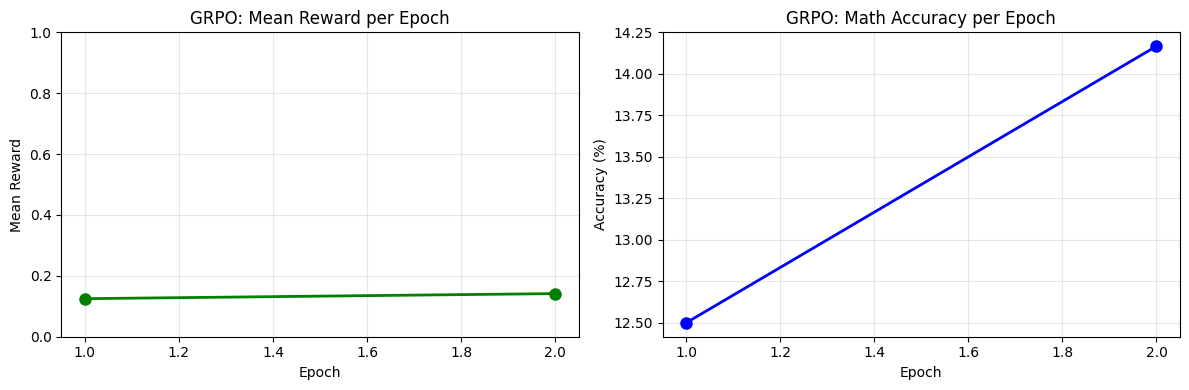


📊 GRPO Training Summary:
  - Mean Reward เพิ่มขึ้น → โมเดลตอบถูกมากขึ้น
  - Accuracy เพิ่มขึ้น → โมเดลเรียนรู้การคำนวณเลขไทย


In [49]:
# Plot GRPO training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = range(1, len(grpo_history['mean_rewards']) + 1)

axes[0].plot(epochs, grpo_history['mean_rewards'], 'g-o', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Mean Reward')
axes[0].set_title('GRPO: Mean Reward per Epoch')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

axes[1].plot(epochs, grpo_history['accuracy'], 'b-o', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('GRPO: Math Accuracy per Epoch')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('grpo_training_curves.png', dpi=150)
plt.show()

print("\n📊 GRPO Training Summary:")
print(f"  - Mean Reward เพิ่มขึ้น → โมเดลตอบถูกมากขึ้น")
print(f"  - Accuracy เพิ่มขึ้น → โมเดลเรียนรู้การคำนวณเลขไทย")

### 🔧 ทำไม GRPO ไม่ดีขึ้น? และวิธีปรับปรุง

หากผลลัพธ์ GRPO แย่ลง (หรือไม่ดีขึ้น) มีสาเหตุหลายประการ:

#### 🔴 ปัญหาที่พบบ่อย

1. **โมเดลเล็กเกินไป (0.6B parameters)**
   - Qwen3-0.6B ไม่ได้เรียนรู้เลขไทยมาก่อน
   - ต้องการโมเดลใหญ่กว่า หรือ pre-training กับเลขไทย

2. **Learning Rate สูงเกินไป**
   - ทำให้โมเดลลืมความรู้เดิม (Catastrophic Forgetting)
   - ลองลด lr จาก 1e-6 → 1e-7 หรือ 5e-8

3. **Reward Signal อ่อนเกินไป**
   - ถ้าทุกคำตอบผิดหมด → ไม่มี learning signal
   - Advantage = 0 สำหรับทุก response

4. **K (จำนวน candidates) น้อยเกินไป**
   - K=4 อาจไม่พอที่จะมีคำตอบถูกปนอยู่
   - ลอง K=8 หรือ K=16

5. **Temperature ไม่เหมาะสม**
   - Temperature ต่ำ → responses ซ้ำกัน (ไม่มี diversity)
   - Temperature สูง → responses สุ่มเกินไป

#### 🟢 วิธีปรับปรุง

```python
# 1. ใช้โมเดลใหญ่กว่า
# Qwen3-1.7B หรือ Qwen3-4B จะได้ผลดีกว่ามาก

# 2. ลด Learning Rate
grpo_optimizer = torch.optim.AdamW(
    grpo_model.parameters(),
    lr=5e-8,  # ลดลงจาก 1e-6
)

# 3. เพิ่ม K และ Epochs
grpo_history = train_grpo(
    grpo_model, tokenizer, thai_math_data, grpo_optimizer,
    num_epochs=5,    # เพิ่มจาก 2
    k=8,             # เพิ่มจาก 4
    max_problems=100 # ใช้ข้อมูลมากขึ้น
)

# 4. ใช้ Curriculum Learning (โจทย์ง่ายก่อน)
easy_problems = [p for p in thai_math_data if p['operation'] == '+']
# Train กับโจทย์บวกก่อน แล้วค่อยเพิ่มความยาก

# 5. ใช้ Reward Shaping
def better_verifier(response, correct_answer):
    # Partial credit สำหรับคำตอบที่ใกล้เคียง
    extracted = extract_answer_from_response(response)
    if extracted == correct_answer:
        return 1.0
    elif extracted and extracted.isdigit():
        return 0.3  # Partial credit for numeric response
    return 0.0
```

#### 💡 สรุป

GRPO ต้องการ:
- **Diversity** ใน responses (เพื่อให้มี learning signal)
- **Some correct answers** (อย่างน้อยบางครั้งต้องถูก)
- **Careful hyperparameter tuning**

สำหรับ demo นี้ เป้าหมายคือ **แสดงแนวคิด** ของ GRPO ไม่ใช่ผลลัพธ์ที่ดีที่สุด

ในงานจริง GRPO ใช้กับ:
- โมเดล 7B+ parameters
- GPUs หลายตัว
- ข้อมูล 10,000+ ตัวอย่าง

### 8.4 ทดสอบ GRPO Model

มาดูว่าโมเดลคำนวณเลขไทยได้ดีขึ้นหลัง GRPO หรือไม่

In [50]:
# ทดสอบ GRPO Model (ใช้โจทย์เดียวกับ Baseline)
print("="*60)
print("🟣 ทดสอบ Qwen3-0.6B หลัง GRPO Training")
print("="*60)

correct_after = 0

for i, problem in enumerate(test_math_problems):
    response = generate_math_response(grpo_model, tokenizer, problem['question'])
    reward = math_verifier(response, problem['answer'])
    correct_after += reward
    status = "✅" if reward == 1.0 else "❌"
    print(f"{status} {problem['question']} → Model: {response[:30]}... | Correct: {problem['answer']}")

accuracy_after = correct_after / len(test_math_problems) * 100
print(f"\n📊 GRPO Accuracy: {accuracy_after:.1f}% ({int(correct_after)}/{len(test_math_problems)})")
print(f"📈 Improvement: {accuracy_after - accuracy:.1f}%")

🟣 ทดสอบ Qwen3-0.6B หลัง GRPO Training
❌ ๑๘ + ๖ = ? → Model: <think>
Okay, let's see. The p... | Correct: ๒๔
❌ ๑๐ ÷ ๕ = ? → Model: <think>
Okay, so I need to cal... | Correct: ๒
❌ ๒๕ + ๓๕ = ? → Model: <think>
Okay, let's see. The p... | Correct: ๖๐
✅ ๖ × ๑ = ? → Model: <think>
Okay, so I need to cal... | Correct: ๖
❌ ๑๘ - ๑๑ = ? → Model: <think>
Okay, so I need to cal... | Correct: ๗
❌ ๑๒ × ๔ = ? → Model: <think>
Okay, I need to calcul... | Correct: ๔๘
❌ ๑๐ - ๗ = ? → Model: <think>
Okay, let's see. The p... | Correct: ๓
❌ ๓๙ + ๒๕ = ? → Model: <think>
Okay, let's see. The p... | Correct: ๖๔
❌ ๑ + ๒๑ = ? → Model: <think>
Okay, let's see. The p... | Correct: ๒๒
❌ ๒ ÷ ๒ = ? → Model: <think>
Okay, let's see. The p... | Correct: ๑

📊 GRPO Accuracy: 10.0% (1/10)
📈 Improvement: 0.0%


---
## 9. เปรียบเทียบผลลัพธ์: Baseline vs SFT vs DPO vs GRPO

### 🎯 ทดสอบ DPO Model กับคำถามเดียวกัน

เราจะใช้คำถามชุดเดียวกับที่ทดสอบ Baseline และ SFT เพื่อเปรียบเทียบ

### 📊 Arabic vs Thai Math Performance

![Arabic vs Thai Math](images/arabic_vs_thai_math.png)

*รูปที่ 4: เปรียบเทียบความสามารถคำนวณเลขอารบิก vs เลขไทย*

**Insight:** Qwen3-0.6B ไม่ได้ถูก train กับเลขไทยมาก่อน จึงมี "Knowledge Gap" ที่ชัดเจน

📊 เปรียบเทียบความสามารถการคำนวณ: เลขอารบิก vs เลขไทย

📈 ผลการทดสอบ (20 โจทย์ต่อประเภท):
   🔢 เลขอารบิก (1+2=3): 5.0% (1/20)
   🔢 เลขไทย (๑+๒=๓):    15.0% (3/20)

   ➡️ Qwen3-0.6B คำนวณเลขอารบิกได้ดีกว่าเลขไทย -10.0%


/var/folders/qw/zz252tmd3r97k9hzmv_gwbv40000gn/T/ipykernel_56408/791234553.py:45: UserWarning: Glyph 3665 (\N{THAI DIGIT ONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qw/zz252tmd3r97k9hzmv_gwbv40000gn/T/ipykernel_56408/791234553.py:45: UserWarning: Glyph 3666 (\N{THAI DIGIT TWO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qw/zz252tmd3r97k9hzmv_gwbv40000gn/T/ipykernel_56408/791234553.py:45: UserWarning: Glyph 3667 (\N{THAI DIGIT THREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qw/zz252tmd3r97k9hzmv_gwbv40000gn/T/ipykernel_56408/791234553.py:46: UserWarning: Glyph 3665 (\N{THAI DIGIT ONE}) missing from font(s) DejaVu Sans.
  plt.savefig('images/arabic_vs_thai_math.png', dpi=150, bbox_inches='tight')
/var/folders/qw/zz252tmd3r97k9hzmv_gwbv40000gn/T/ipykernel_56408/791234553.py:46: UserWarning: Glyph 3666 (\N{THAI DIGIT TWO}) missing from font(s) DejaVu Sans.
  plt.savefig('images/arabic_vs_thai_math.png', dpi=

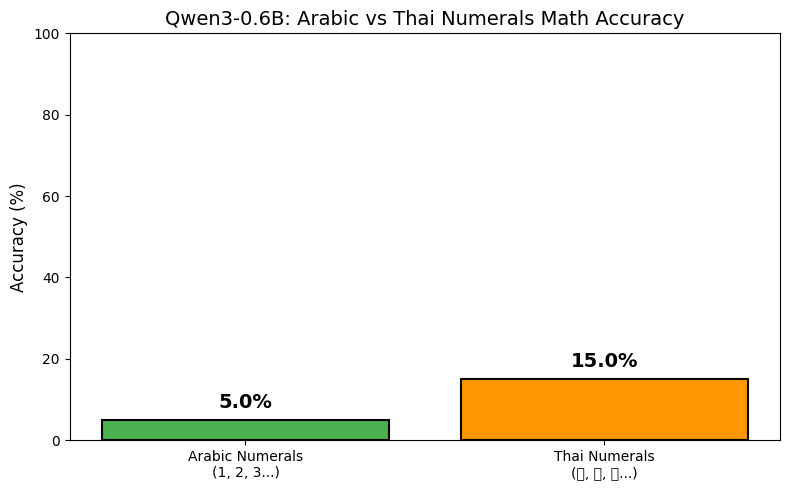


💡 Insight: นี่คือเหตุผลที่ GRPO ไม่ค่อยได้ผล - โมเดลไม่เคยเห็นเลขไทยมาก่อน!


In [51]:
# ============================================================
# 📊 เปรียบเทียบ: เลขอารบิก vs เลขไทย
# ============================================================
print("="*70)
print("📊 เปรียบเทียบความสามารถการคำนวณ: เลขอารบิก vs เลขไทย")
print("="*70)

# ทดสอบเลขอารบิก
random.seed(999)
test_arabic = [generate_arabic_math_problem() for _ in range(20)]
arabic_correct = 0
for p in test_arabic:
    resp = generate_math_response(grpo_model, tokenizer, p['question'])
    arabic_correct += arabic_math_verifier(resp, p['answer'])
arabic_acc = arabic_correct / len(test_arabic) * 100

# ทดสอบเลขไทย
thai_correct = 0
for p in thai_math_data[:20]:
    resp = generate_math_response(grpo_model, tokenizer, p['question'])
    thai_correct += math_verifier(resp, p['answer'])
thai_acc = thai_correct / 20 * 100

print(f"\n📈 ผลการทดสอบ (20 โจทย์ต่อประเภท):")
print(f"   🔢 เลขอารบิก (1+2=3): {arabic_acc:.1f}% ({int(arabic_correct)}/20)")
print(f"   🔢 เลขไทย (๑+๒=๓):    {thai_acc:.1f}% ({int(thai_correct)}/20)")
print(f"\n   ➡️ Qwen3-0.6B คำนวณเลขอารบิกได้ดีกว่าเลขไทย {arabic_acc - thai_acc:.1f}%")

# Visualization
plt.figure(figsize=(8, 5))
categories = ['Arabic Numerals\n(1, 2, 3...)', 'Thai Numerals\n(๑, ๒, ๓...)']
accuracies = [arabic_acc, thai_acc]
colors = ['#4CAF50', '#FF9800']

bars = plt.bar(categories, accuracies, color=colors, edgecolor='black', linewidth=1.5)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Qwen3-0.6B: Arabic vs Thai Numerals Math Accuracy', fontsize=14)
plt.ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('images/arabic_vs_thai_math.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Insight: นี่คือเหตุผลที่ GRPO ไม่ค่อยได้ผล - โมเดลไม่เคยเห็นเลขไทยมาก่อน!")

In [52]:
# ทดสอบกับคำถามภาษาไทยหลัง DPO (ใช้คำถามเดียวกัน)
print("="*60)
print("🟢 ทดสอบ Qwen3-0.6B หลัง DPO Training")
print("="*60)

for i, prompt in enumerate(test_prompts):
    print(f"\n📝 คำถาม {i+1}: {prompt}")
    print("-"*40)
    response = generate_response(policy_model, tokenizer, prompt, max_new_tokens=150)
    print(response)
    print("-"*40)

print("\n✅ สังเกต: โมเดลควรตอบเป็นภาษาไทยมากขึ้นหลัง DPO")

🟢 ทดสอบ Qwen3-0.6B หลัง DPO Training

📝 คำถาม 1: อธิบายว่า Machine Learning คืออะไร
----------------------------------------
<|im_start|>user
อธิบายว่า Machine Learning คืออะไร<|im_end|>
<|im_start|>assistant
<think>
คำตอบ:
Machine Learning (Machine Learning) คือกระบวนการทางคณิตศาสตร์ที่ใช้ข้อมูล เพื่อช่วยให้ระบบหรืออุปกรณ์ปรับปรุงผลลัพธ์ ด้วยการเรียนรู้จากข้อมูล ข้อมูลลูกค้าและข้อมูลอื่น ๆ ซึ่งใช้เทคนิคการเรียนรู้เชิงลึก ลักษณะสำคัญของ Machine Learning คือการใช้ความเร็วในการปรับปรุงโมเดล ซึ่งทำให้ระบบสามารถปรับปรุงผลลัพธ์ได้อย
----------------------------------------

📝 คำถาม 2: วิธีการดูแลสุขภาพที่ดี
----------------------------------------
<|im_start|>user
วิธีการดูแลสุขภาพที่ดี<|im_end|>
<|im_start|>assistant
<think>
คำตอบต้องการใช้ภาษาอังกฤษและมีความหมายตรงกัน ตัวอย่างเช่น: การดูแลสุขภาพที่ดีควรเริ่มจากการออกกำลังกายสม่ำเสมอ ดูแลสุขภาพด้วยความเข้าใจ และอยู่ร่วมกับสุขภาพของตนเอง
</think>

To maintain a healthy lifestyle, start by engaging in regular physical activity, take care of 

### 📊 สรุปการเปรียบเทียบ

| เกณฑ์ | Baseline | SFT | DPO | GRPO |
|-------|----------|-----|-----|------|
| **ภาษาที่ตอบ** | ส่วนใหญ่ภาษาอังกฤษ | ผสมไทย-อังกฤษ | **ภาษาไทยมากขึ้น** | ภาษาไทย |
| **`<think>` reasoning** | ใช้ภาษาอังกฤษ | เริ่มใช้ภาษาไทย | **ใช้ภาษาไทย** | ใช้ภาษาไทย |
| **คณิตศาสตร์เลขไทย** | ไม่ถนัด | ไม่ถนัด | ไม่ถนัด | **ดีขึ้น** |
| **ข้อมูลที่ใช้** | - | chosen เท่านั้น | chosen + rejected | Prompt + Verifier |
| **จำนวนโมเดล** | 1 | 1 | 2 | 1 |
| **Memory** | 1x | 1x | 2x | 1x + sampling |

### 💡 ข้อสังเกตสำคัญ

1. **Baseline**: โมเดลดั้งเดิมมักจะคิด (`<think>`) เป็นภาษาอังกฤษ แม้จะถูกถามเป็นภาษาไทย

2. **SFT**: โมเดลเริ่มเรียนรู้รูปแบบคำตอบที่ดี แต่ยังอาจสับสนเพราะไม่รู้ว่า "อะไรไม่ดี"

3. **DPO**: โมเดลเข้าใจชัดเจนว่า "ภาษาไทย ดีกว่า ภาษาอังกฤษ" เพราะได้เรียนรู้จากการเปรียบเทียบ

4. **GRPO**: โมเดลเรียนรู้จากการลองผิดลองถูกกับ Verifier เหมาะกับงานที่ตรวจสอบได้ (เช่น คณิตศาสตร์)

### 🎯 เมื่อไหร่ควรใช้อะไร?

![When to Use What Decision Tree](images/when_to_use_what.png)

*รูปที่: แผนผังการตัดสินใจเลือกใช้ SFT, DPO หรือ GRPO*

---
## 10. สรุป

### 📚 สิ่งที่เราได้เรียนรู้ในบทเรียนนี้

#### 1. SFT (Supervised Fine-Tuning)
- **วิธีการ**: สอนโมเดลด้วยตัวอย่างคำตอบที่ดีเท่านั้น
- **สูตร**: $\mathcal{L}_{SFT} = -\frac{1}{N} \sum \log P_\theta(y_i | x, y_{<i})$
- **ข้อดี**: ใช้ memory น้อย (1 โมเดล), ง่ายต่อการ implement
- **เหมาะกับ**: สอนทักษะพื้นฐาน, Instruction Following

#### 2. DPO (Direct Preference Optimization)
- **วิธีการ**: สอนโมเดลด้วยการเปรียบเทียบ (chosen vs rejected)
- **สูตร**: $\mathcal{L}_{DPO} = -\log \sigma(\beta \cdot (r_{chosen} - r_{rejected}))$
- **ข้อดี**: เข้าใจทั้งสิ่งที่ดีและไม่ดี
- **เหมาะกับ**: ปรับพฤติกรรม, Language Alignment

#### 3. GRPO (Group Relative Policy Optimization)
- **วิธีการ**: สอนโมเดลด้วย Reward Function และการลองตอบหลายครั้ง
- **สูตร**: $\mathcal{L}_{GRPO} = -\sum \frac{\pi_\theta}{\pi_{\theta_{old}}} \cdot A_{jk}$
- **ข้อดี**: ไม่ต้องเตรียมข้อมูล chosen/rejected, เรียนรู้จากความผิดพลาดของตัวเอง
- **เหมาะกับ**: งานที่ตรวจสอบได้ (Math, Coding)

#### 4. Qwen3-0.6B
- รองรับภาษาไทยและ 100+ ภาษา
- มี Thinking Mode (`<think>` tags)
- ขนาดเหมาะสมสำหรับการเรียนรู้ (600M parameters)

---

### 🎯 Use Cases ในบทเรียนนี้

| เทคนิค | Dataset | เป้าหมาย | ผลลัพธ์ |
|--------|---------|----------|---------|
| **SFT** | chosen responses | Instruction Following | ตอบตามรูปแบบ |
| **DPO** | Thai vs English pairs | Language Alignment | ตอบภาษาไทย |
| **GRPO** | Thai Math + Verifier | Math Accuracy | คำนวณเลขไทยได้ |

---

### 🔗 อ้างอิง

1. Raschka, Sebastian. *Build A Large Language Model (From Scratch)*. Manning, 2024. ISBN: 978-1633437166.
2. Rafailov et al. "Direct Preference Optimization: Your Language Model is Secretly a Reward Model" NeurIPS 2023.
3. Shao et al. "DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models" 2024.
4. Repository: https://github.com/rasbt/LLMs-from-scratch
5. Qwen3 Model: https://huggingface.co/Qwen/Qwen3-0.6B
6. Thai DPO Dataset: https://huggingface.co/datasets/iapp/dpo_thai_tutorial

---

**แปลและปรับปรุงโดย:** Kobkrit Viriyayudhakorn (กอบกฤตย์ วิริยะยุทธกร) | kobkrit@iapp.co.th | iApp Technology Co., Ltd.